# Titanic Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#set visualization style
sns.set_style("darkgrid")

In [4]:
df=pd.read_csv("Titanic Dataset.csv")

#display basic info
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [6]:
# Rename columns based on inferred meaning from the first row
df.columns = ["pclass", "survived", "name", "sex", "age", "sibsb", "parch","ticket","fare", "cabin","embarked","boat","body", "home.dest"]

# Drop the first row, which appears to be an incorrect header
df = df.iloc[1:].reset_index(drop=True)

# Display updated structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1308 non-null   int64  
 1   survived   1308 non-null   int64  
 2   name       1308 non-null   object 
 3   sex        1308 non-null   object 
 4   age        1045 non-null   float64
 5   sibsb      1308 non-null   int64  
 6   parch      1308 non-null   int64  
 7   ticket     1308 non-null   object 
 8   fare       1307 non-null   float64
 9   cabin      294 non-null    object 
 10  embarked   1306 non-null   object 
 11  boat       485 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  744 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


# **Data cleaning**

**Handling Missing values**

In [13]:
# Handle missing values

def fill_if_exists(df, column, fill_value):
    if column in df.columns:
        missing_before = df[column].isnull().sum()
        df[column].fillna(fill_value, inplace=True)
        missing_after = df[column].isnull().sum()
        print(f"Filled {missing_before - missing_after} missing values in '{column}'")

fill_if_exists(df, 'age', df['age'].median())
fill_if_exists(df, 'fare', df['fare'].median())
fill_if_exists(df, 'embarked', df['embarked'].mode()[0])
fill_if_exists(df, 'home.dest', 'Unknown')

Filled 0 missing values in 'age'
Filled 0 missing values in 'fare'
Filled 0 missing values in 'embarked'
Filled 0 missing values in 'home.dest'


<ipython-input-13-e9f17150533c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(fill_value, inplace=True)


In [15]:
# Drop columns with too many missing values (only if they exist)
columns_to_drop = ['cabin', 'boat', 'body']
existing_columns = [col for col in columns_to_drop if col in df.columns]
if existing_columns:
    df.drop(columns=existing_columns, inplace=True)
    print(f"Dropped columns: {existing_columns}")

In [16]:
# Drop remaining rows with missing values (if any)
rows_before = df.shape[0]
df.dropna(inplace=True)
rows_after = df.shape[0]
print(f"Dropped {rows_before - rows_after} rows with remaining missing values")

Dropped 0 rows with remaining missing values


**Identify and remove duplicate records.**

In [17]:
# Remove duplicate records
initial_shape = df.shape
df.drop_duplicates(inplace=True)
final_shape = df.shape

print(f"\nRemoved {initial_shape[0] - final_shape[0]} duplicate rows.")



Removed 0 duplicate rows.


In [18]:
# Verify missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum().sum())  # Total remaining missing values


Missing values after handling:
0


**Detect and treat outliers using appropriate statistical methods.**

In [21]:
# Detect and treat outliers using IQR method

def cap_outliers(df, column):
    if column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        df[column] = df[column].clip(lower_bound, upper_bound)
        outliers_after = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

        print(f"Capped {outliers_before - outliers_after} outliers in '{column}'")

cap_outliers(df, 'age')
cap_outliers(df, 'fare')
df.shape

Capped 0 outliers in 'age'
Capped 0 outliers in 'fare'


(744, 11)

In [24]:
# Standardize categorical values

def standardize_text(df, columns):
    for col in columns:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].str.strip().str.lower().str.capitalize()
            print(f"Standardized text values in '{col}'")

categorical_cols = ['sex', 'embarked', 'pclass', 'home.dest']
standardize_text(df, categorical_cols)


Standardized text values in 'sex'
Standardized text values in 'embarked'
Standardized text values in 'home.dest'


# **2. Exploratory Data Analysis (EDA):**

**Univariate Analysis (Single-Variable Exploration)**

**Summary statistics (mean, median, mode, variance, skewness, etc.).**

In [25]:
# Univariate Analysis: Summary statistics

def univariate_analysis(df, columns):
    for col in columns:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            print(f"\nSummary statistics for '{col}':")
            print(df[col].describe())
            print(f"Skewness: {df[col].skew()} | Kurtosis: {df[col].kurt()}")

numeric_cols = df.select_dtypes(include='number').columns.tolist()
univariate_analysis(df, numeric_cols)


Summary statistics for 'pclass':
count    744.000000
mean       1.875000
std        0.796506
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: pclass, dtype: float64
Skewness: 0.2275876956922714 | Kurtosis: -1.389888357193276

Summary statistics for 'survived':
count    744.000000
mean       0.465054
std        0.499113
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: survived, dtype: float64
Skewness: 0.14041086912289513 | Kurtosis: -1.9856297575670336

Summary statistics for 'age':
count    744.000000
mean      31.499160
std       14.460311
min        0.170000
25%       22.000000
50%       28.000000
75%       40.625000
max       68.562500
Name: age, dtype: float64
Skewness: 0.29366701985807364 | Kurtosis: -0.11529876164755626

Summary statistics for 'sibsb':
count    744.000000
mean       0.526882
std        0.858386
min        0.000000
25%        0.000000
50%        0.00

**Frequency distributions for categorical variables.**

In [26]:
# Frequency distribution for categorical variables

def frequency_distribution(df, columns):
    for col in columns:
        if col in df.columns and df[col].dtype == 'object':
            print(f"\nFrequency distribution for '{col}':")
            print(df[col].value_counts())

frequency_distribution(df, categorical_cols)


Frequency distribution for 'sex':
sex
Male      457
Female    287
Name: count, dtype: int64

Frequency distribution for 'embarked':
embarked
S    535
C    172
Q     37
Name: count, dtype: int64

Frequency distribution for 'home.dest':
home.dest
New york, ny                                    64
London                                          14
Montreal, pq                                    10
Cornwall / akron, oh                             9
Paris, france                                    9
                                                ..
Chelsea, london                                  1
Harrow-on-the-hill, middlesex                    1
Copenhagen, denmark                              1
Guernsey / montclair, nj and/or toledo, ohio     1
Antwerp, belgium / stanton, oh                   1
Name: count, Length: 369, dtype: int64


**Histograms and box plots to visualize distributions.**

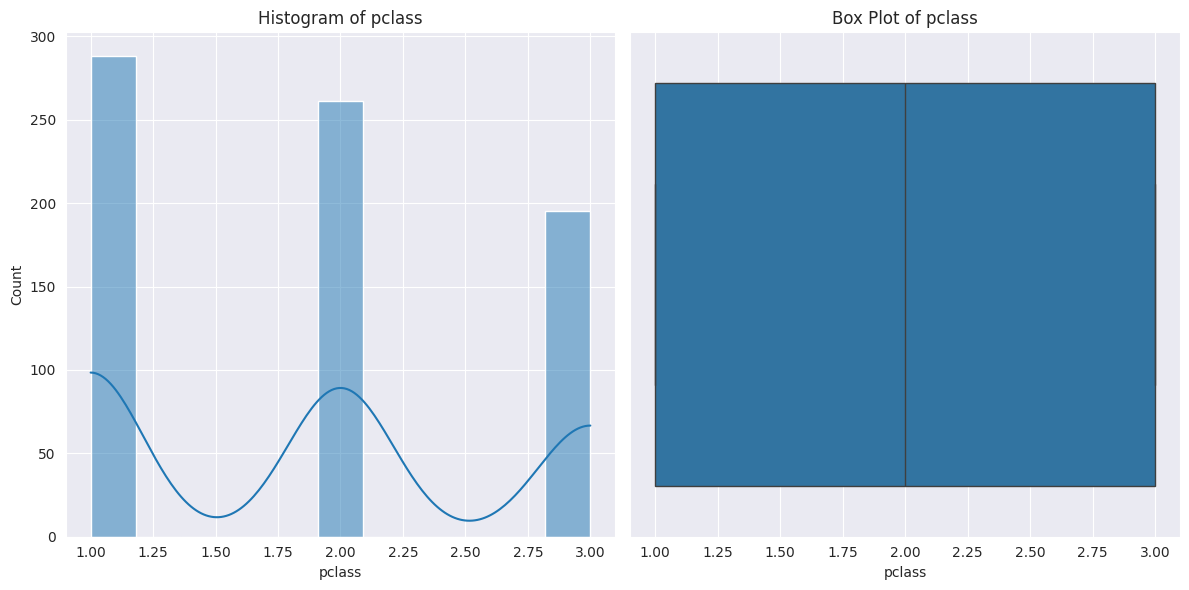

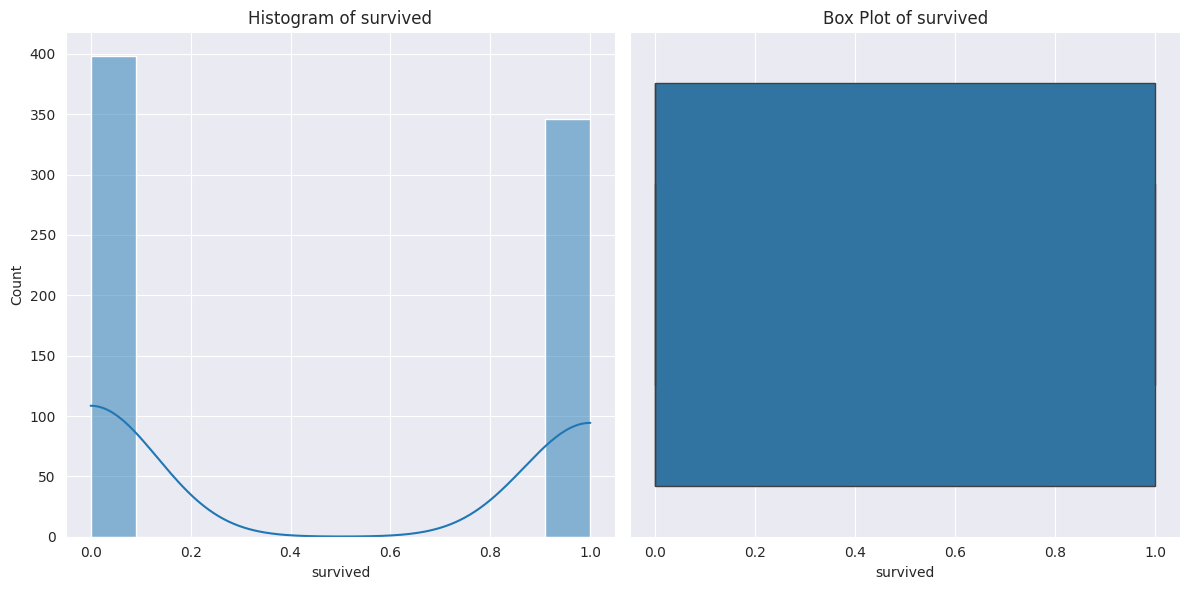

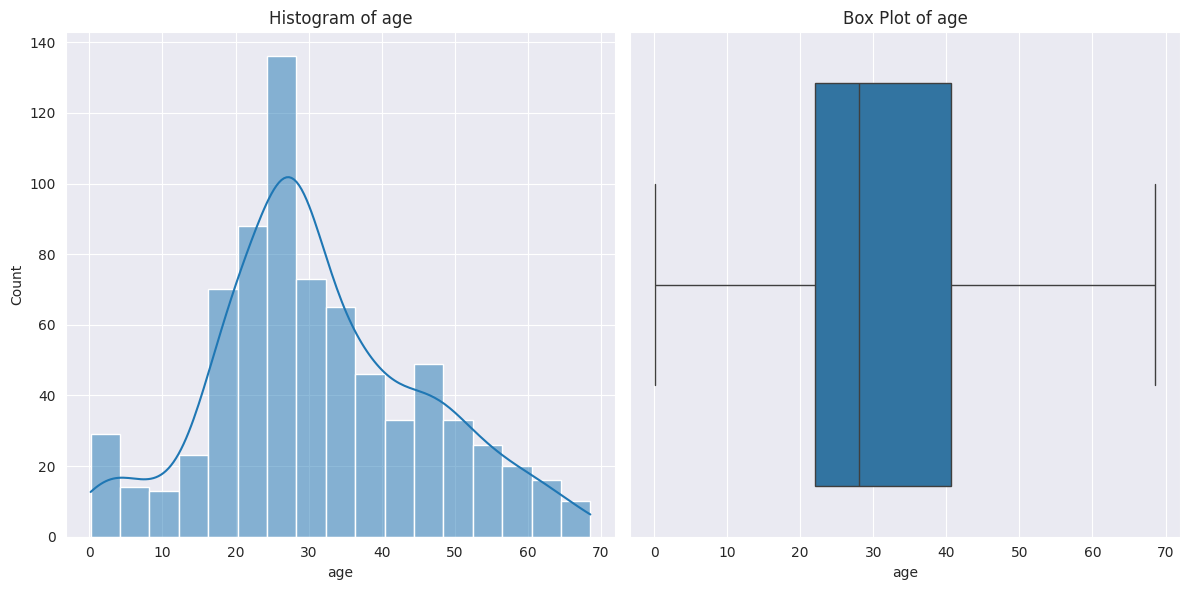

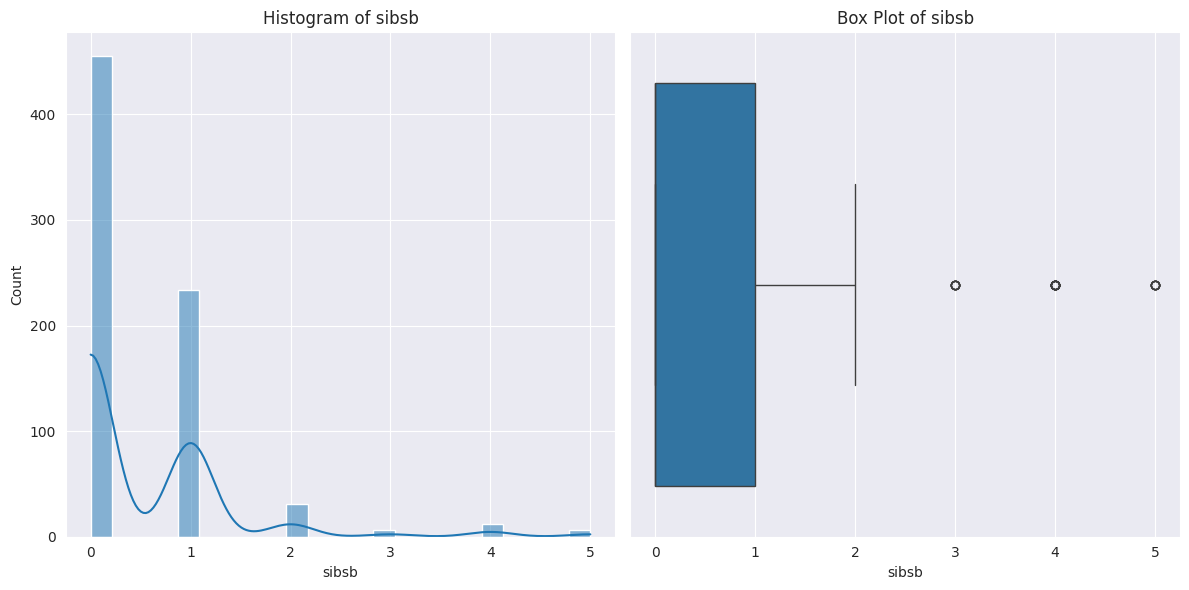

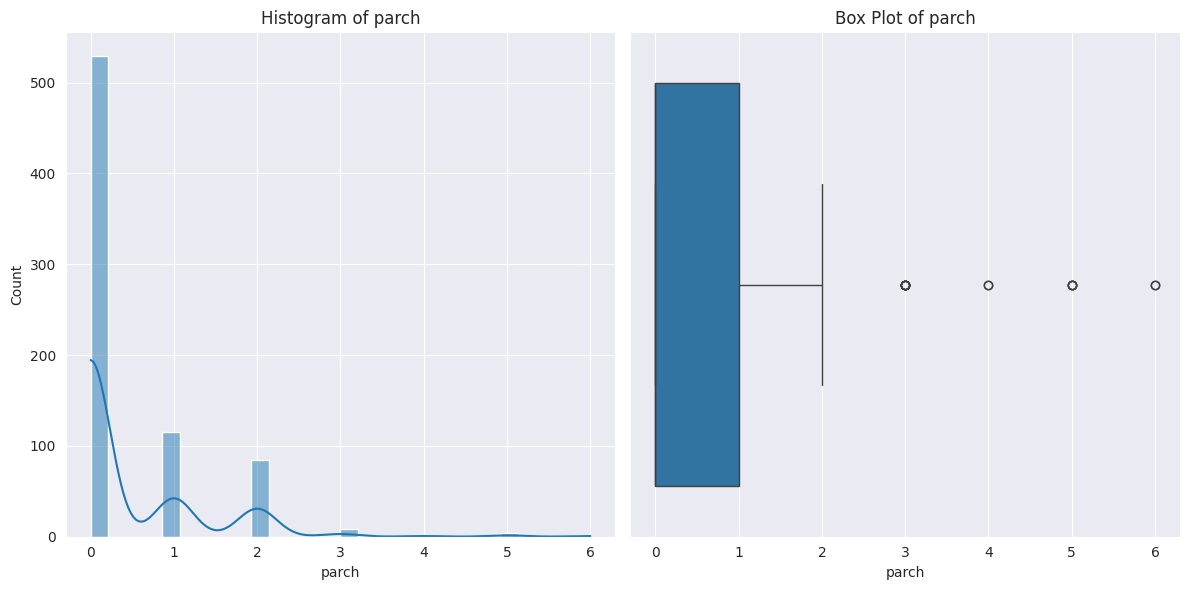

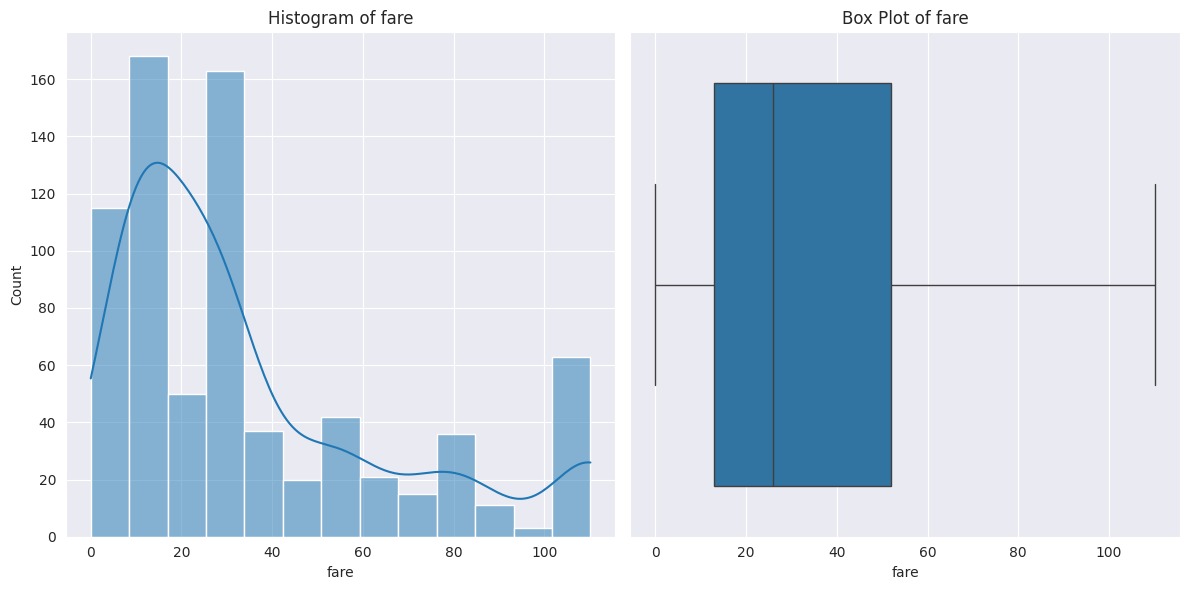

In [27]:
# Visualizations: Histograms and Box Plots

def visualize_distributions(df, numeric_cols):
    for col in numeric_cols:
        if col in df.columns:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.histplot(df[col], kde=True)
            plt.title(f"Histogram of {col}")

            plt.subplot(1, 2, 2)
            sns.boxplot(x=df[col])
            plt.title(f"Box Plot of {col}")

            plt.tight_layout()
            plt.show()

visualize_distributions(df, numeric_cols)

**Bivariate Analysis (Two-Variable Exploration)**

**Correlation matrix to identify relationships between numerical variables.**

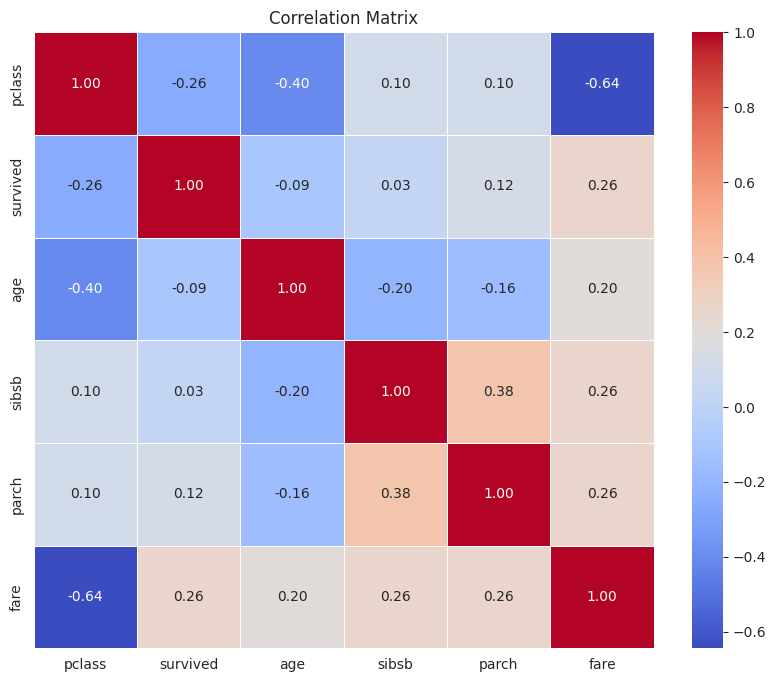

In [29]:
# Correlation matrix (exclude non-numeric columns)

def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include='number')  # Keep only numeric columns
    corr_matrix = numeric_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

plot_correlation_matrix(df)

**Scatter plots for continuous variable relationships.**

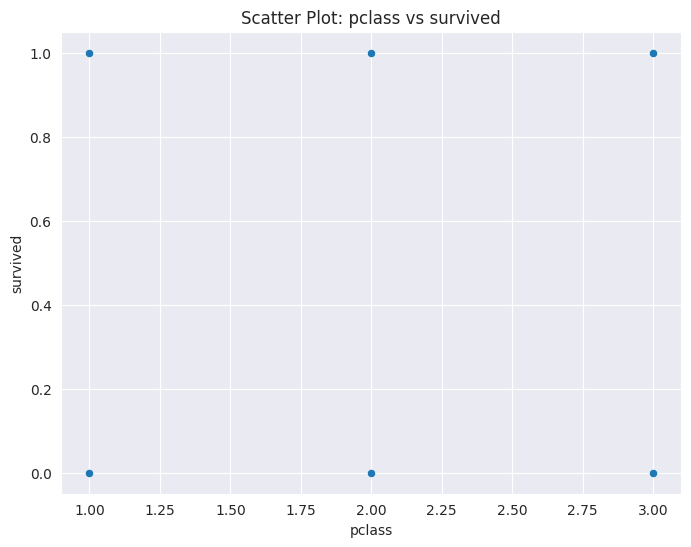

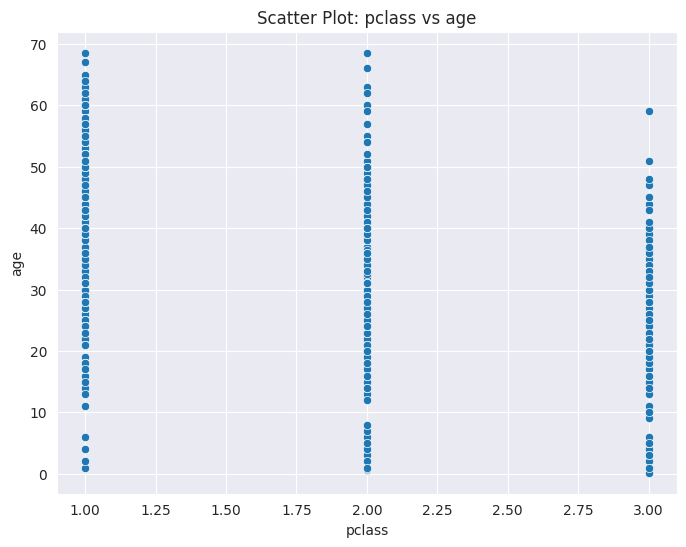

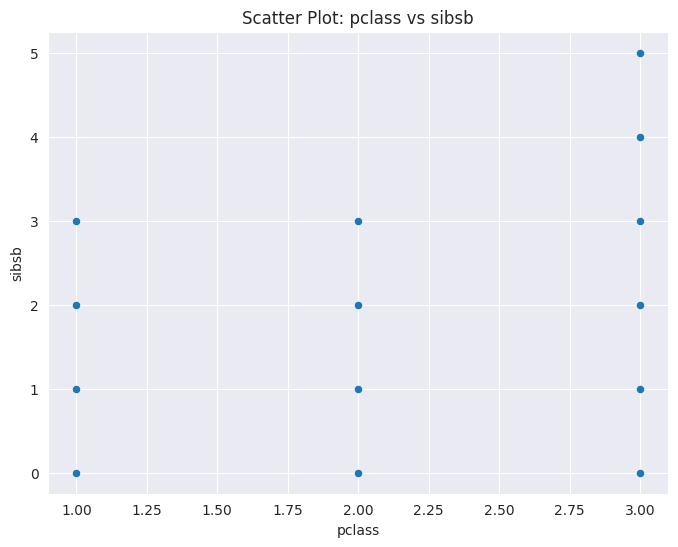

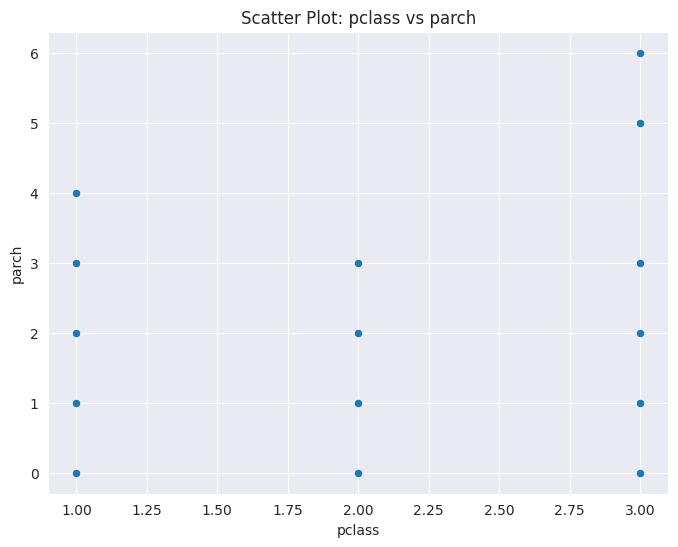

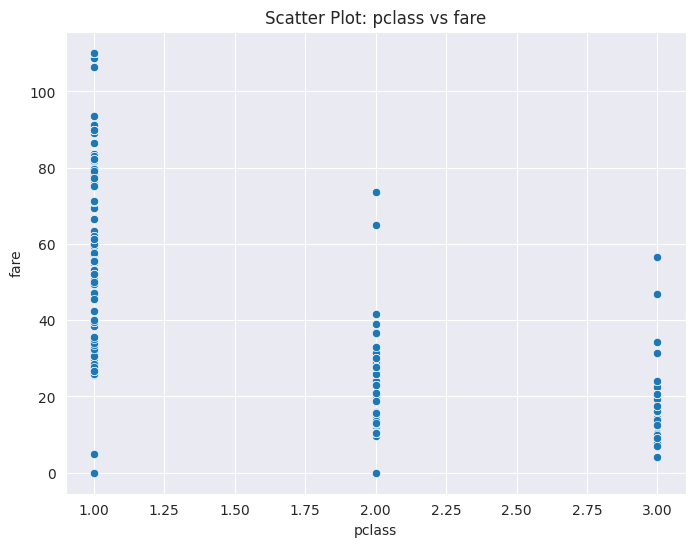

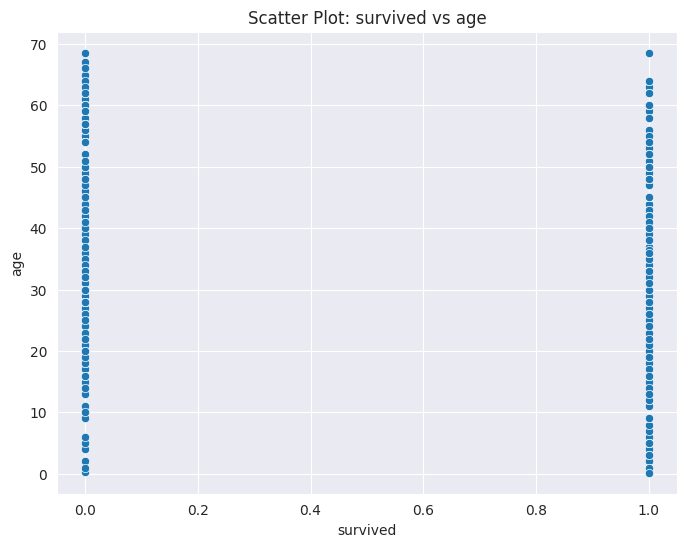

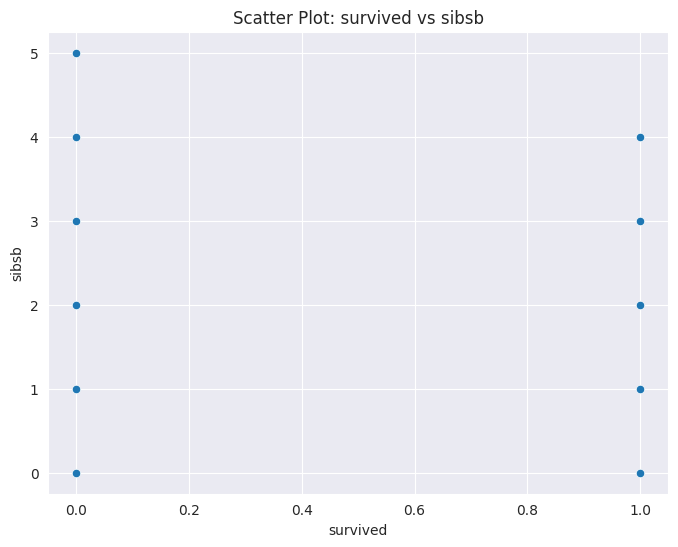

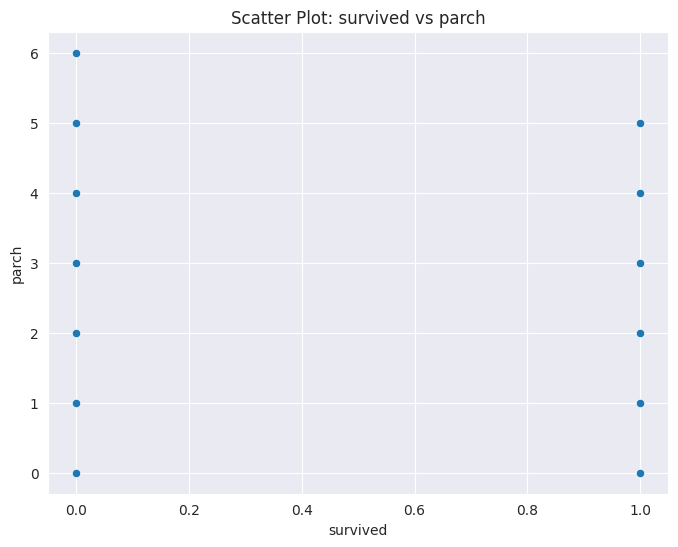

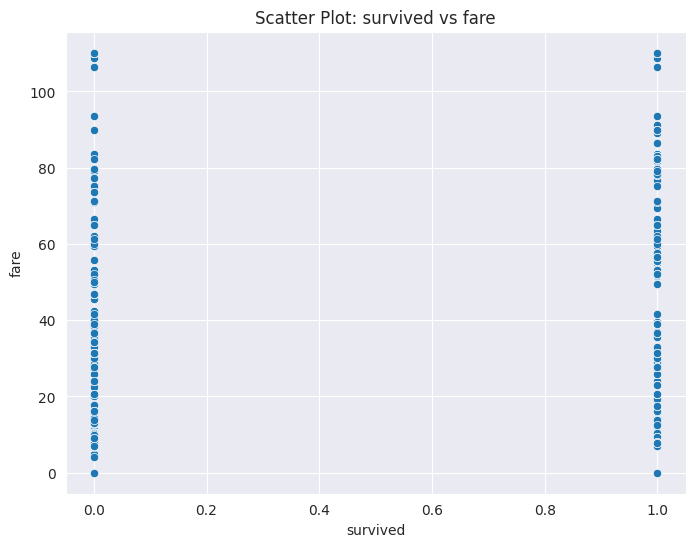

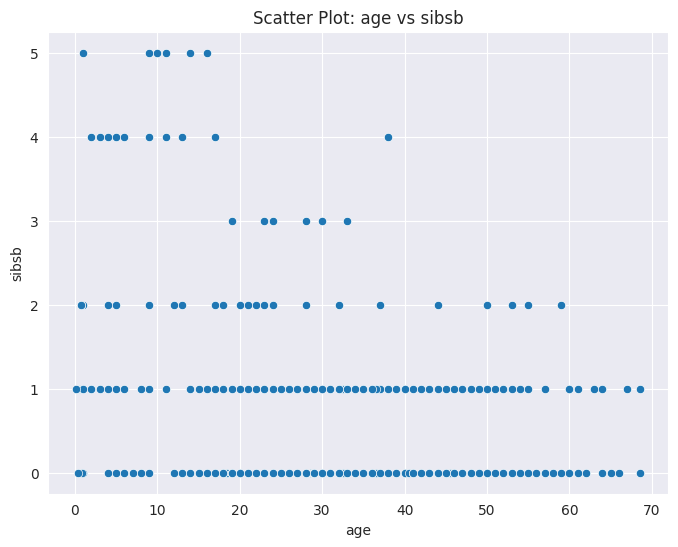

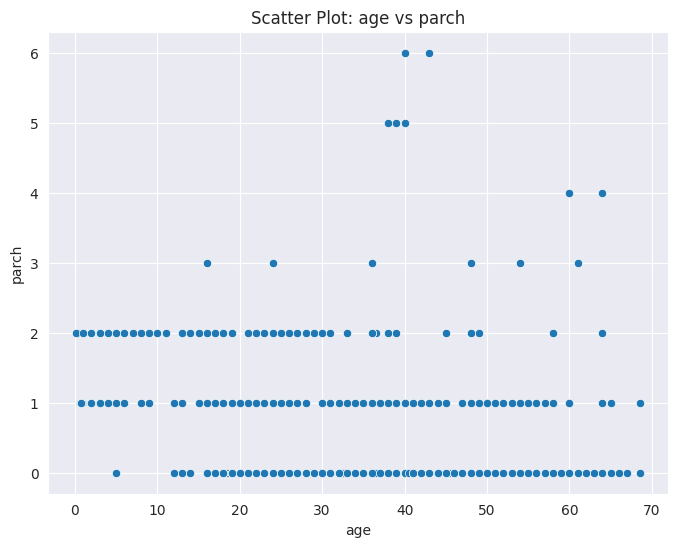

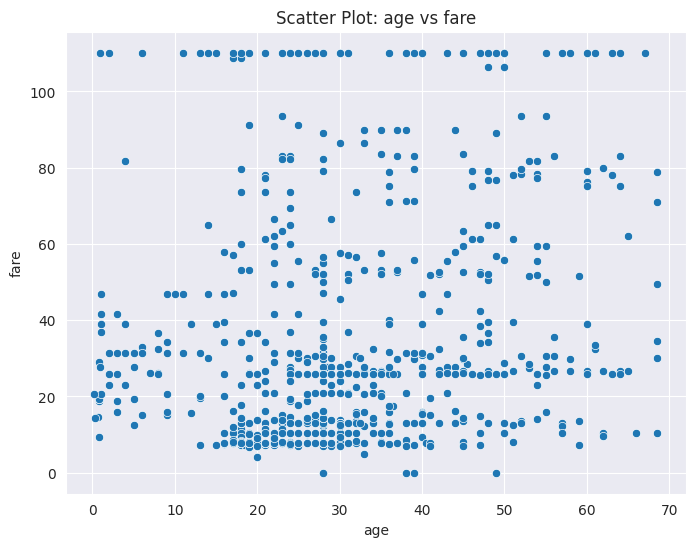

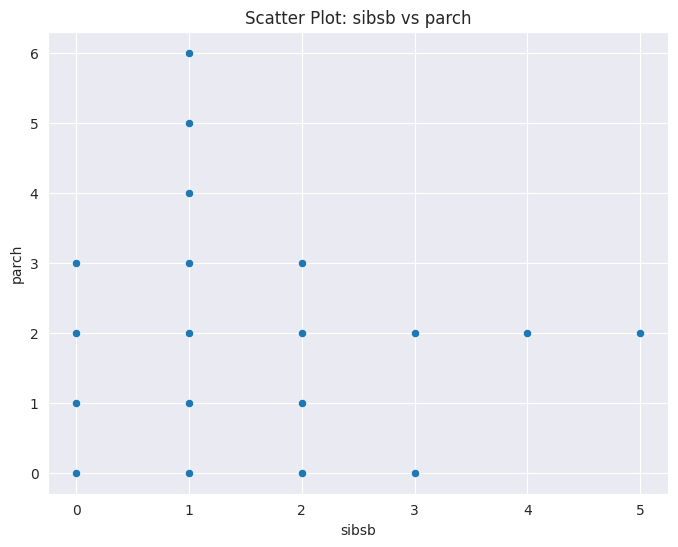

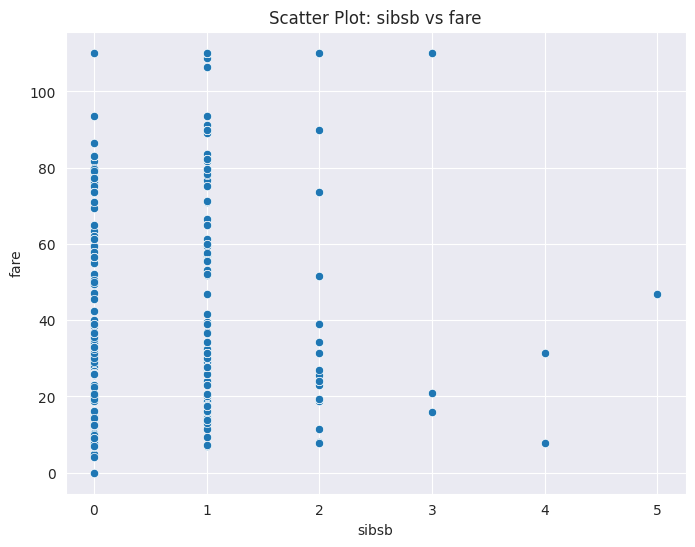

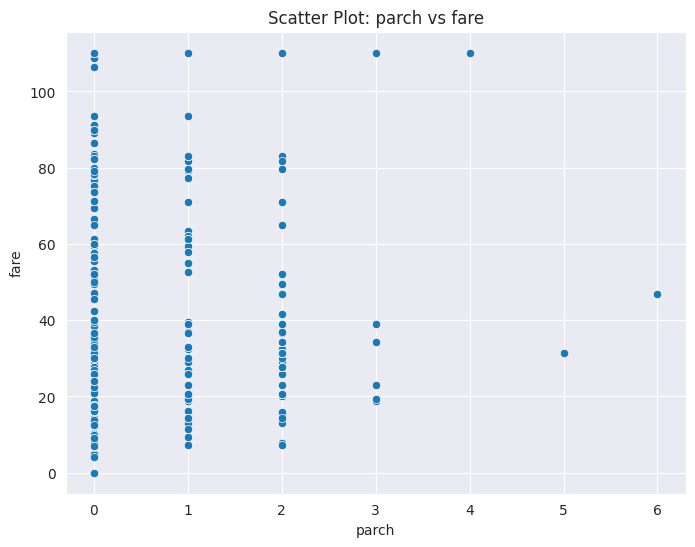

In [30]:
# Scatter plots for continuous variable relationships

def scatter_plots(df, numeric_cols):
    for i in range(len(numeric_cols)):
        for j in range(i + 1, len(numeric_cols)):
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=df[numeric_cols[i]], y=df[numeric_cols[j]])
            plt.title(f"Scatter Plot: {numeric_cols[i]} vs {numeric_cols[j]}")
            plt.show()

scatter_plots(df, numeric_cols)

**Bar plots, violin plots, and box plots to compare categorical and numerical variables.**

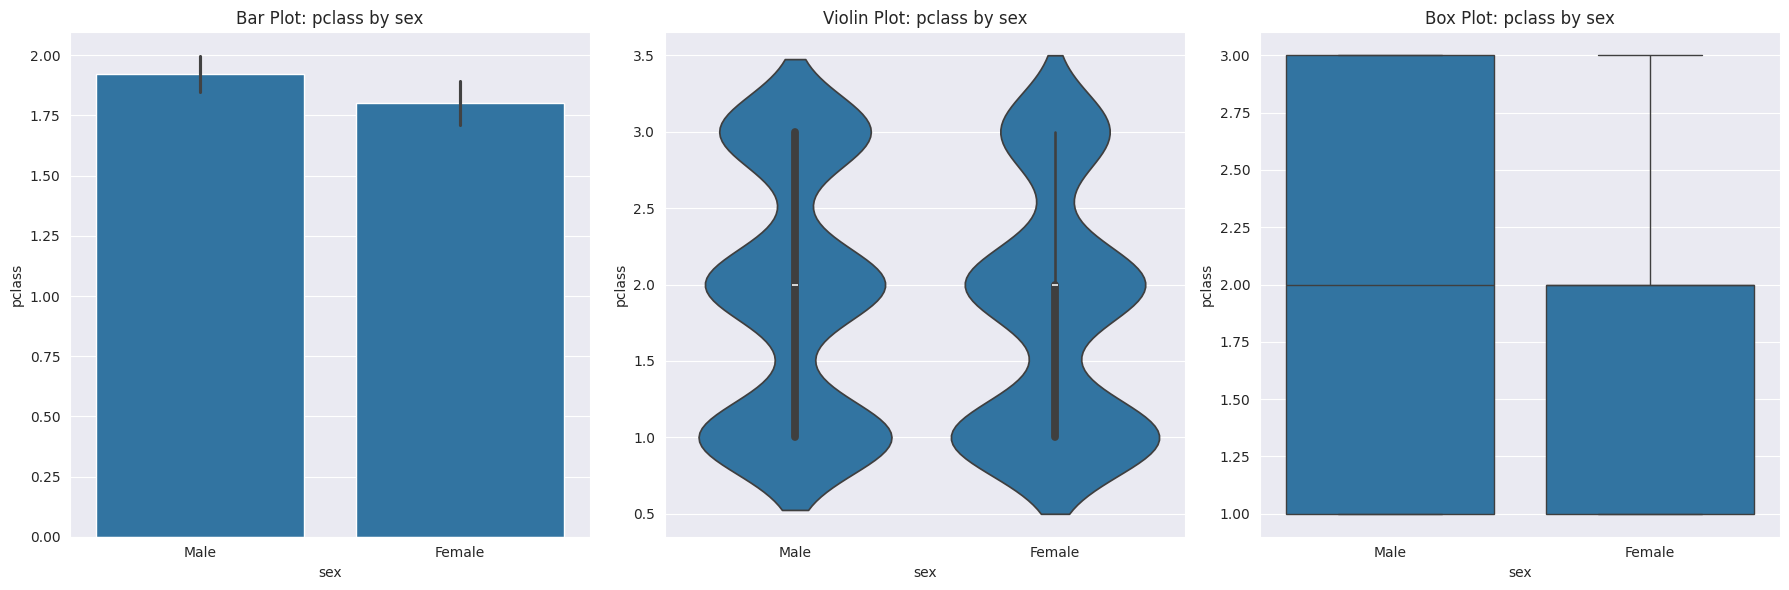

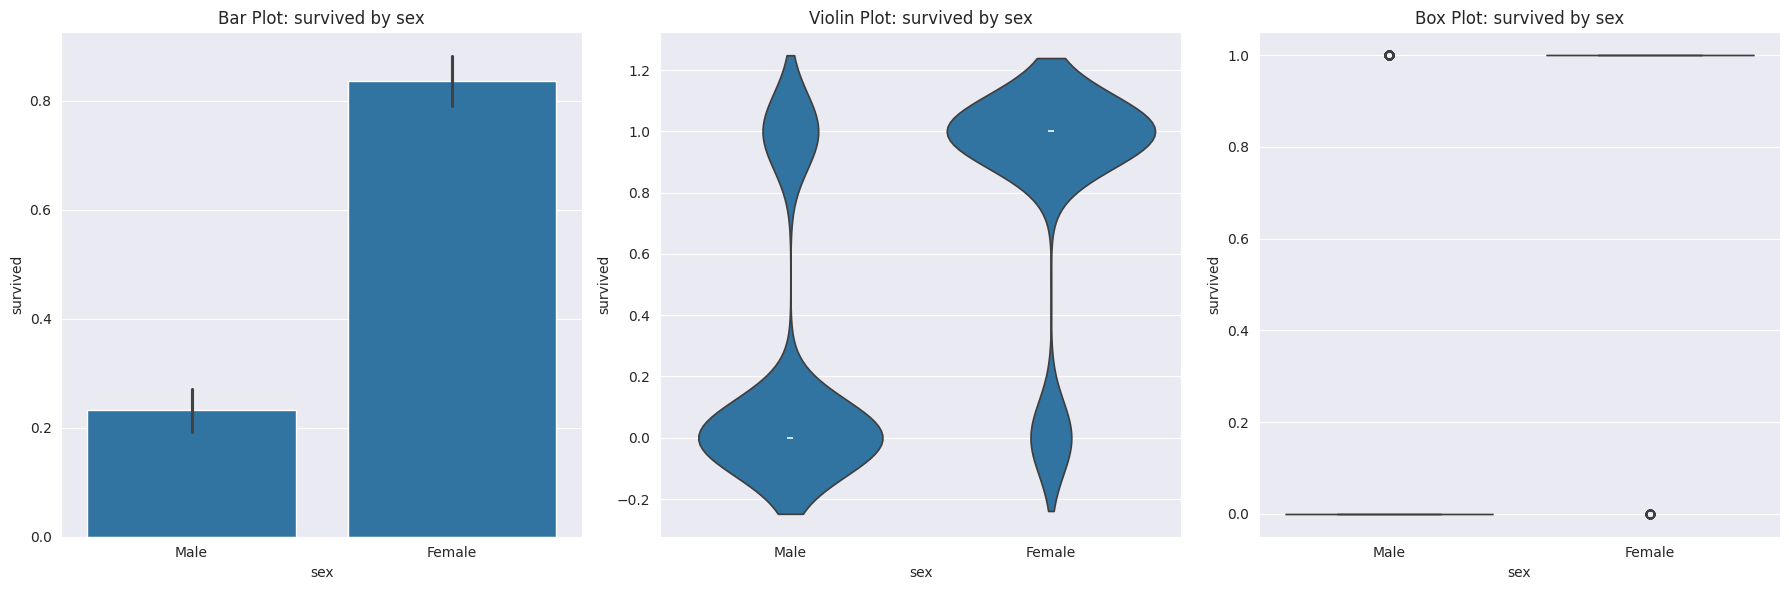

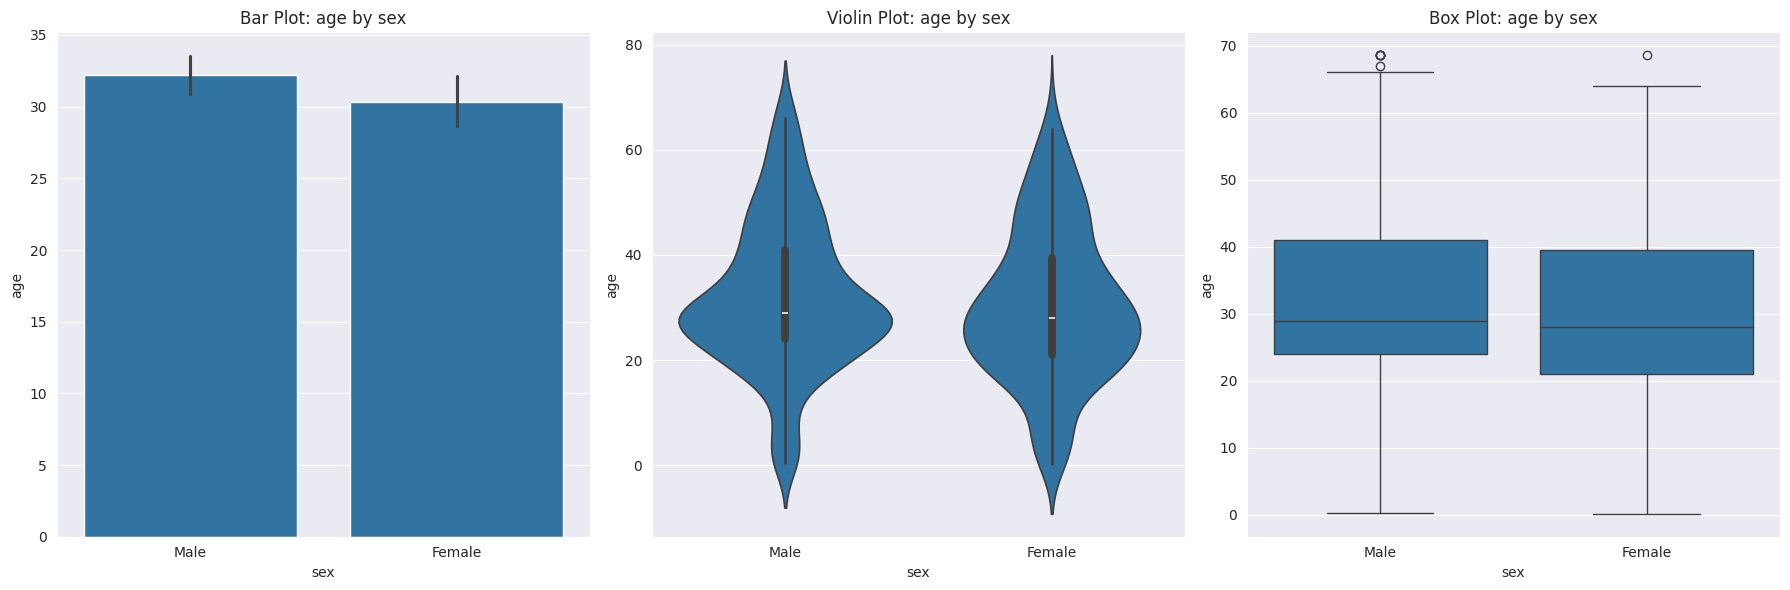

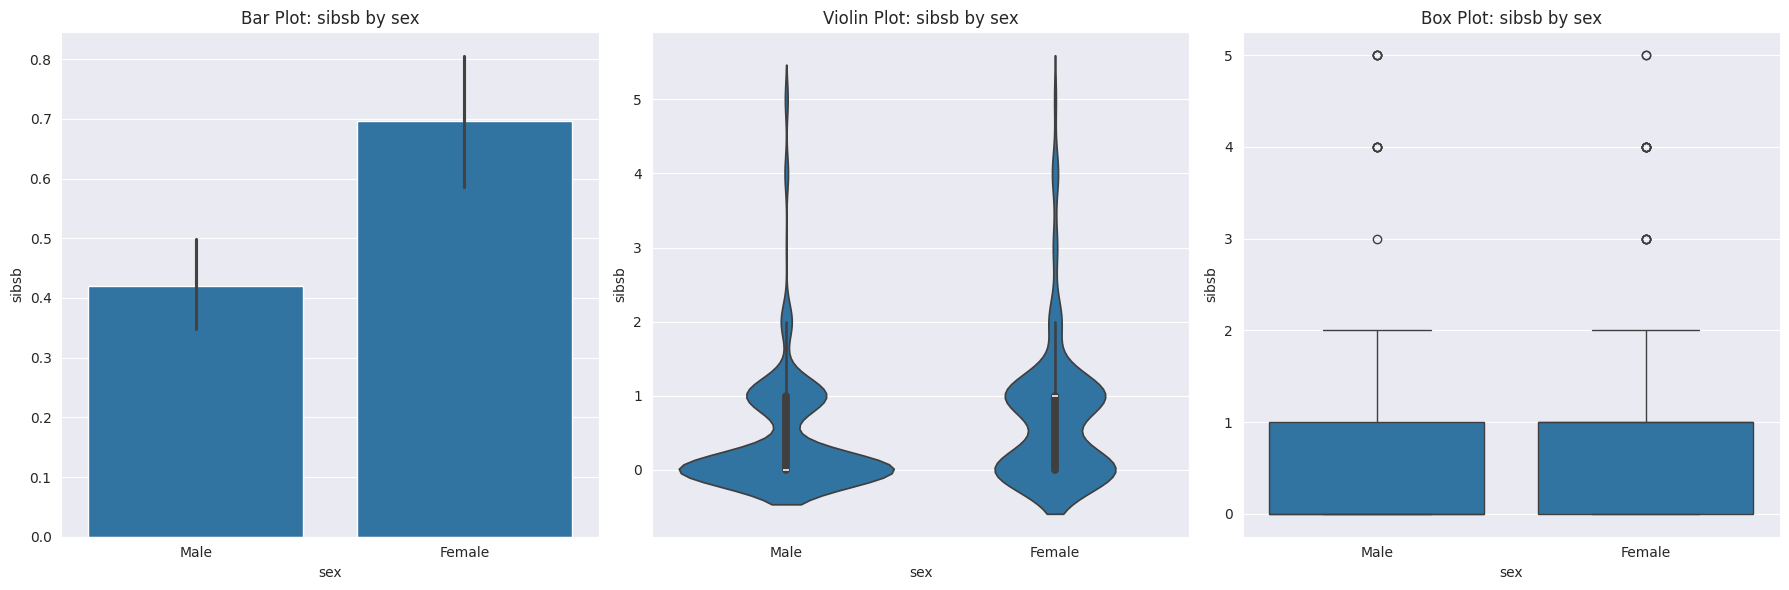

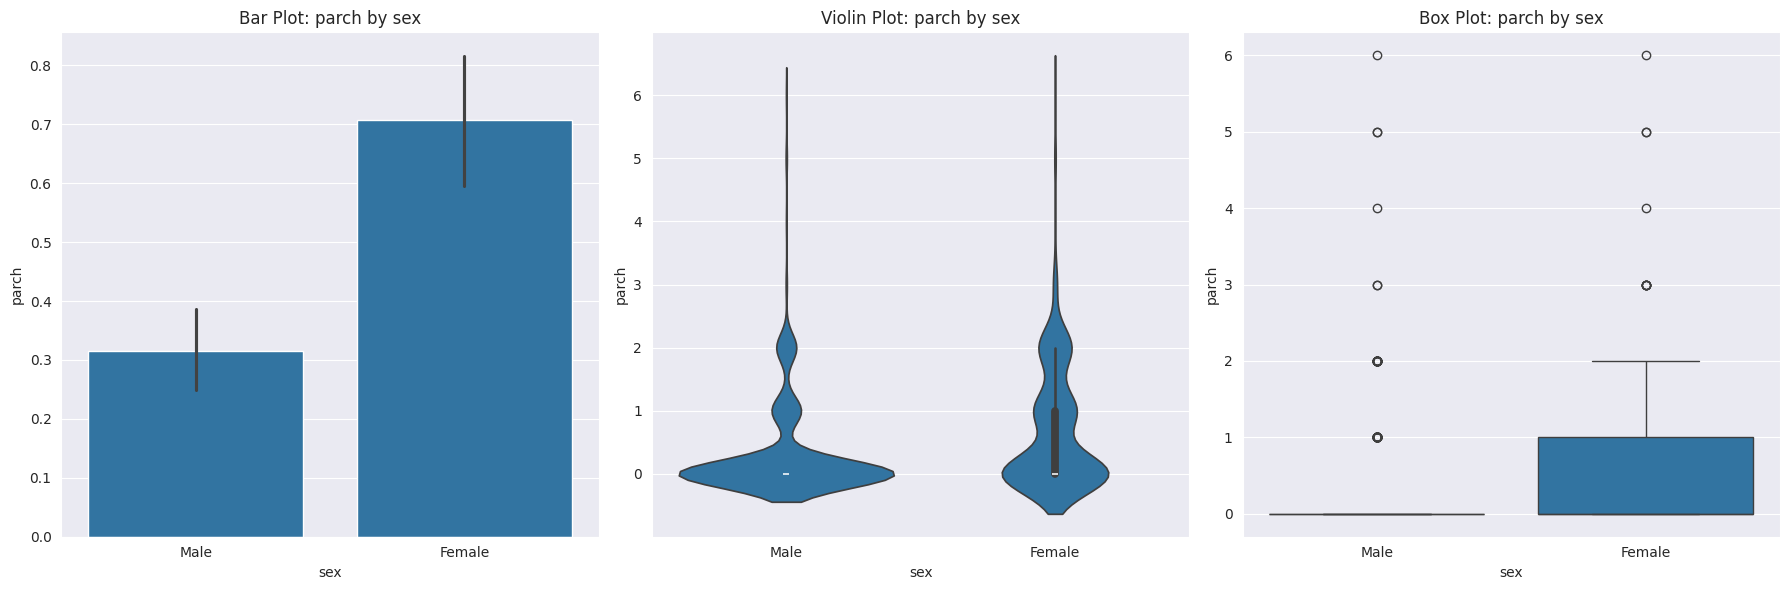

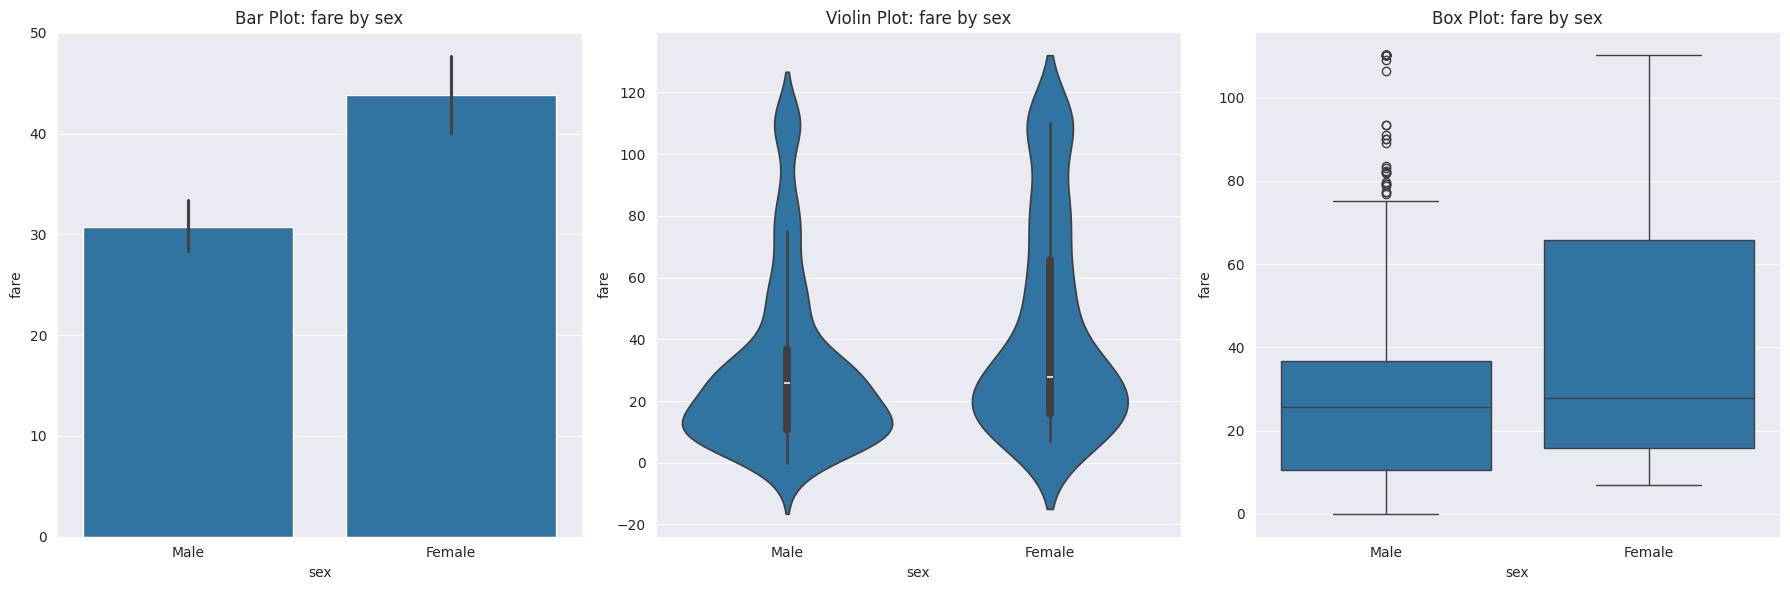

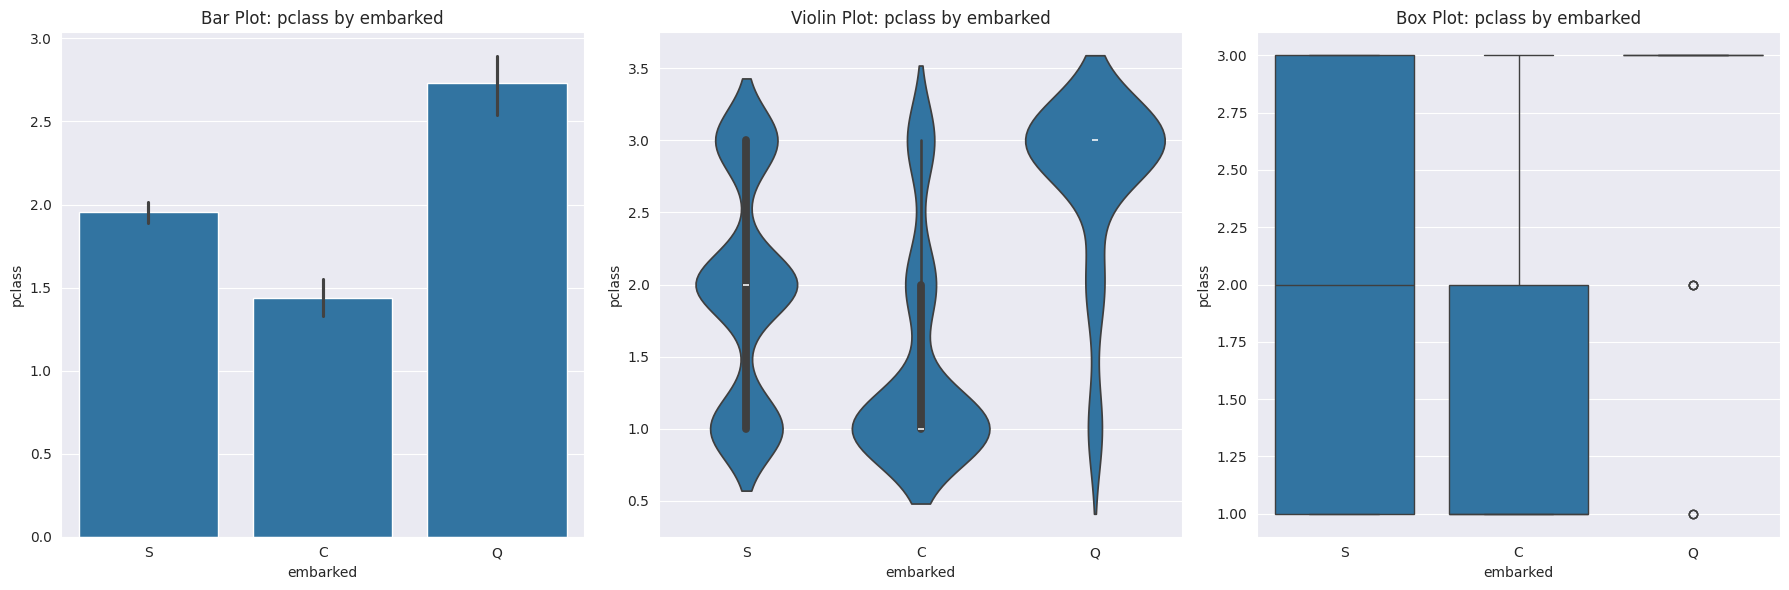

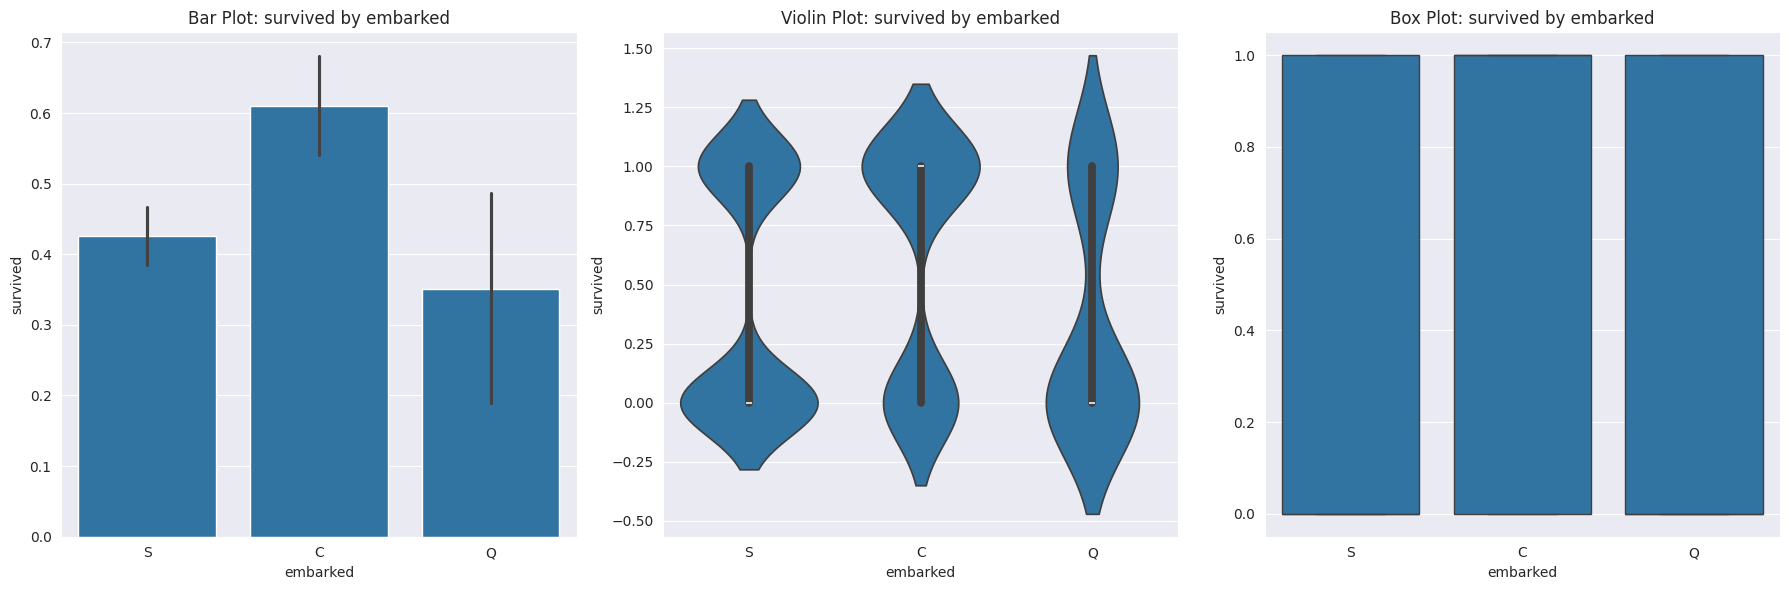

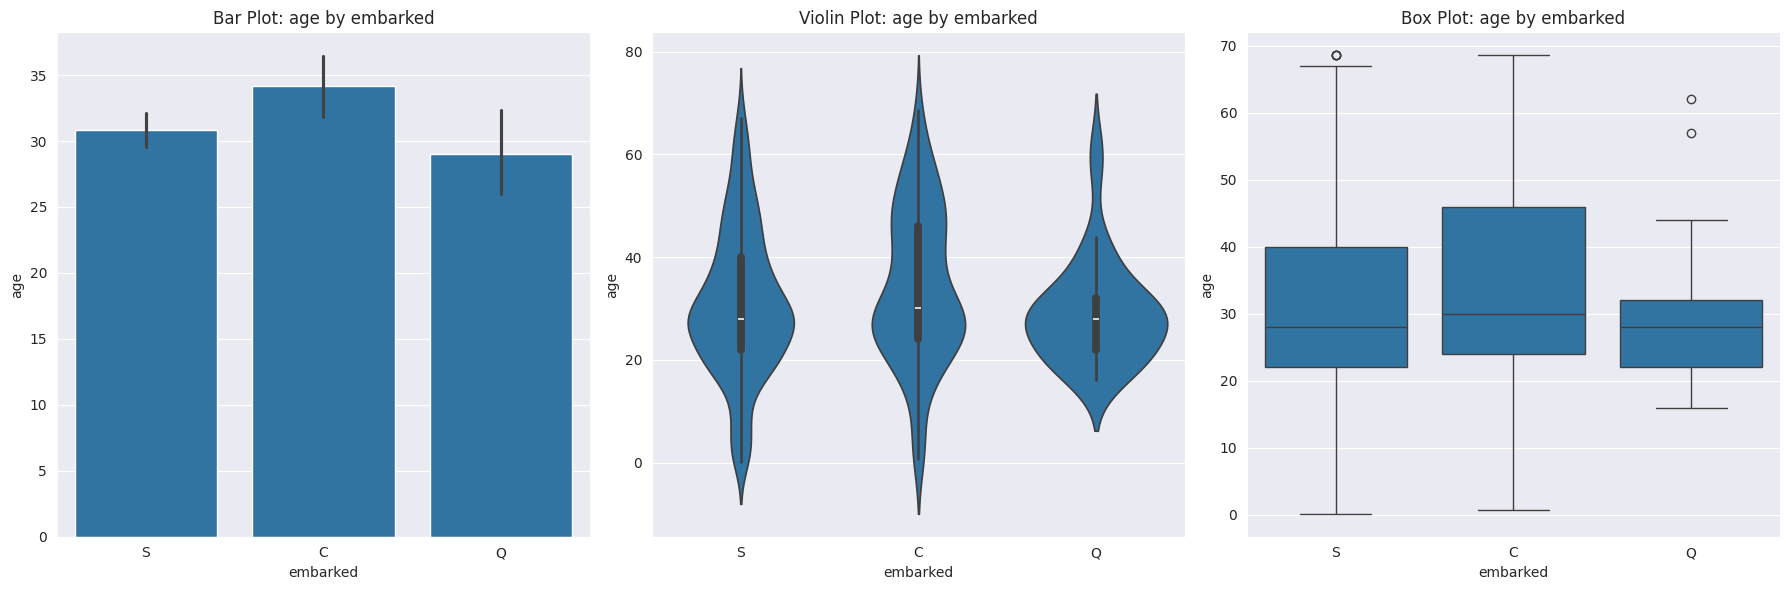

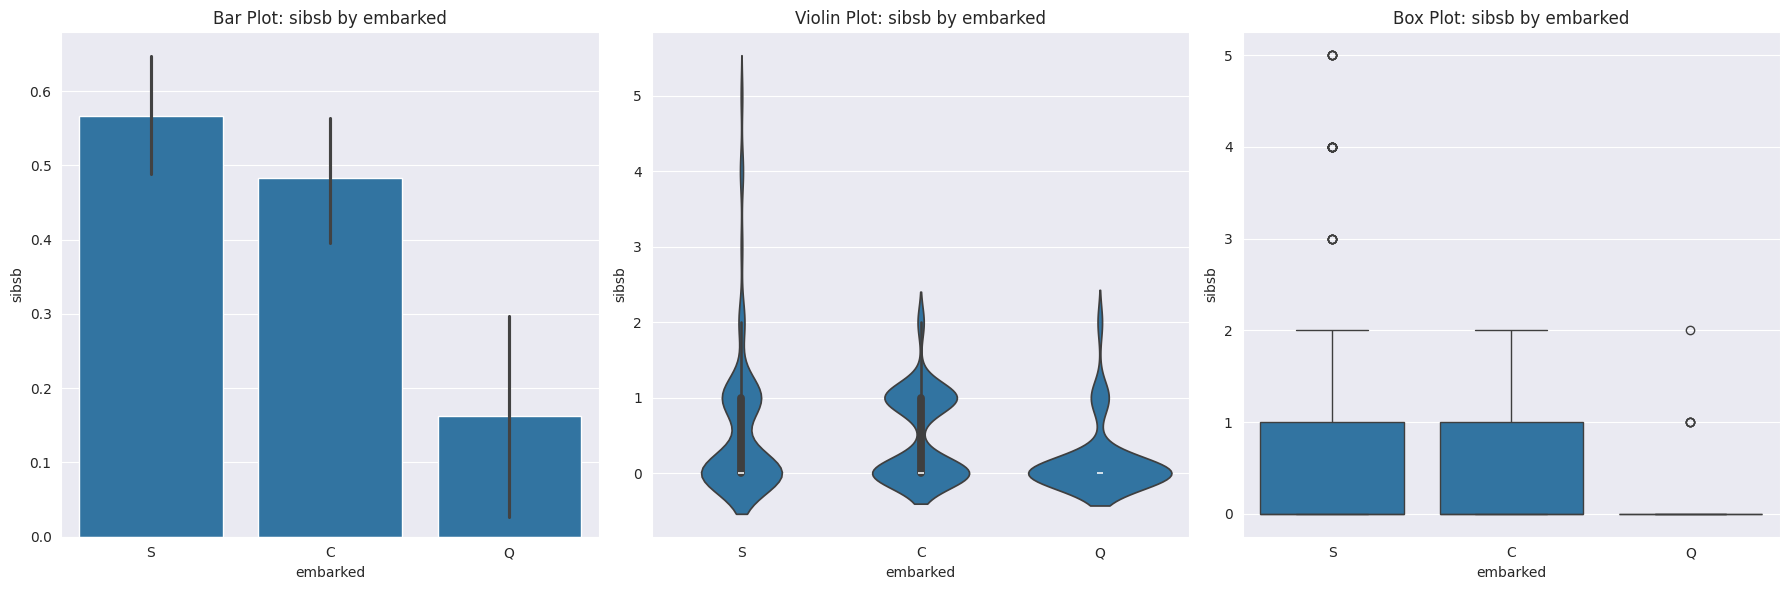

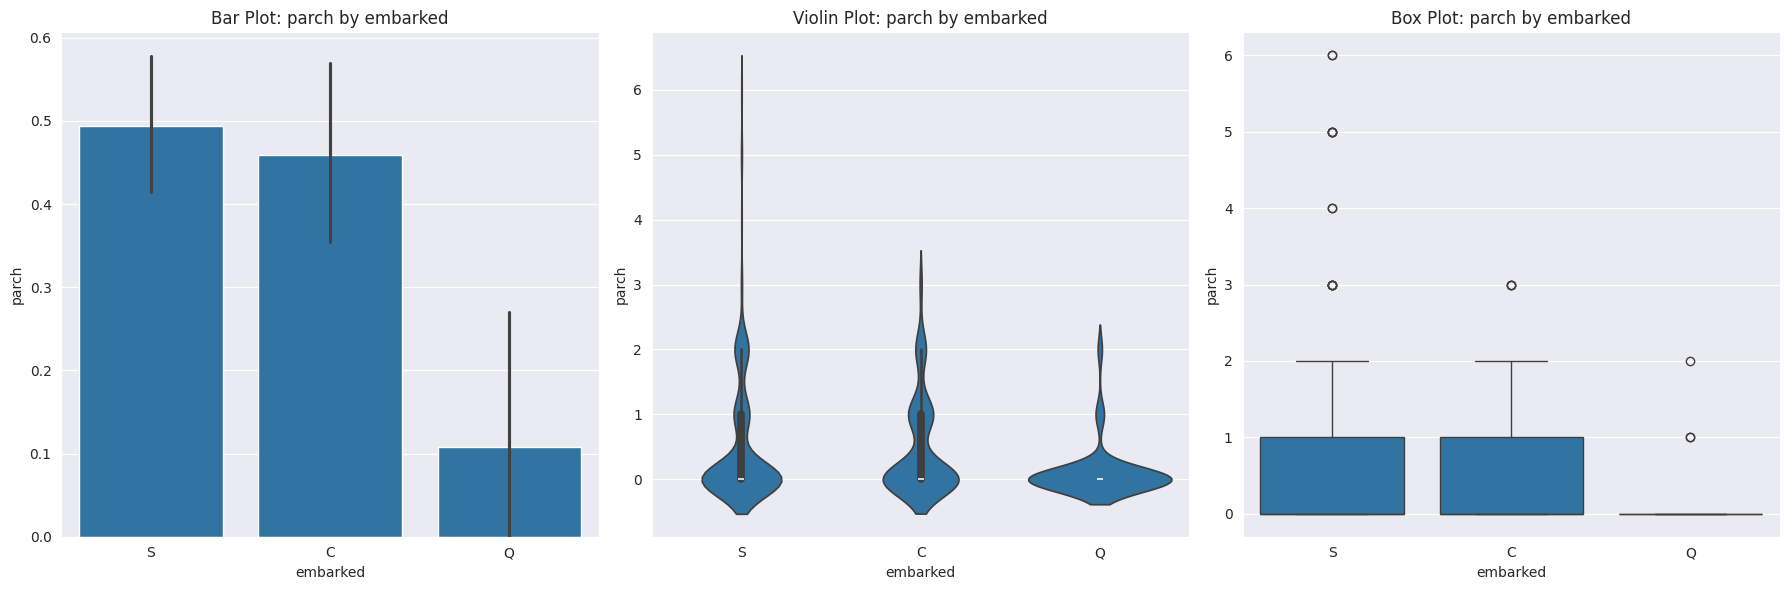

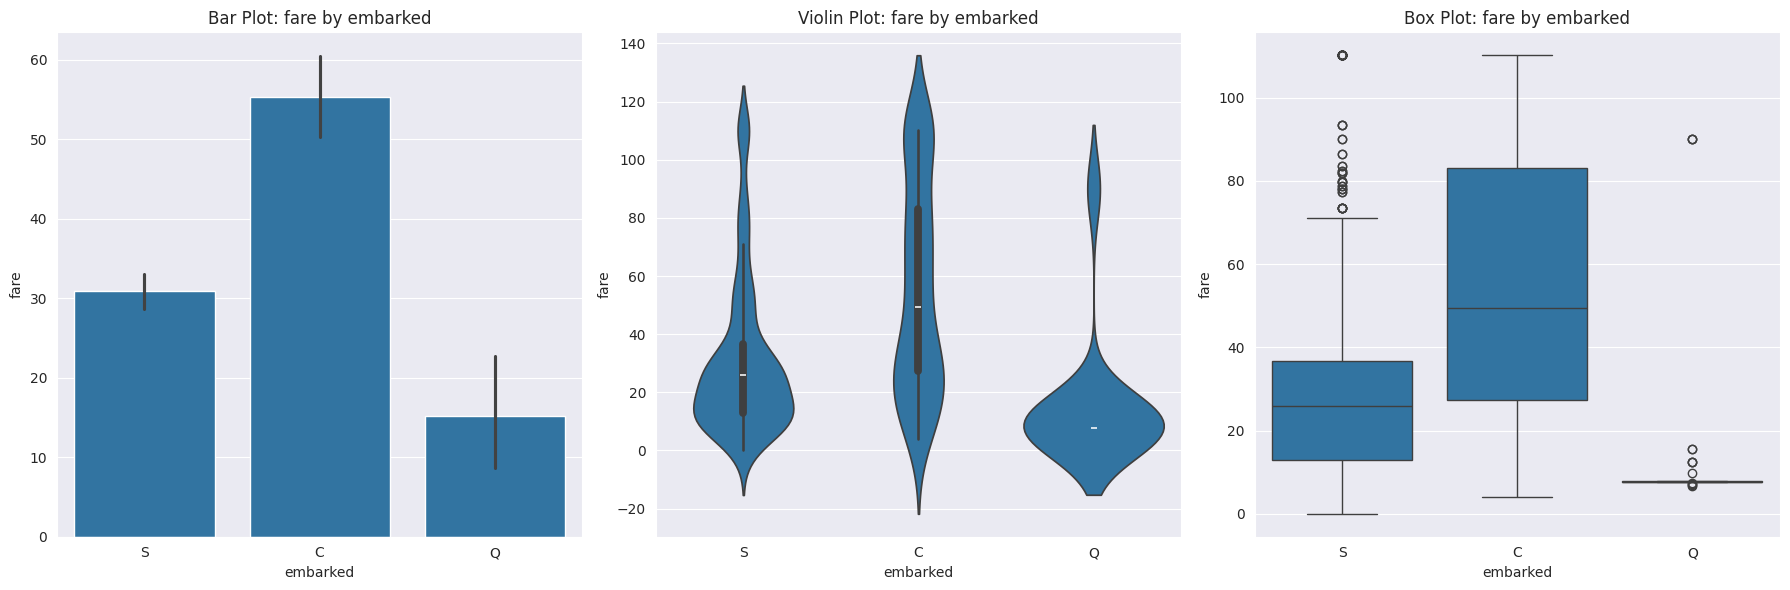

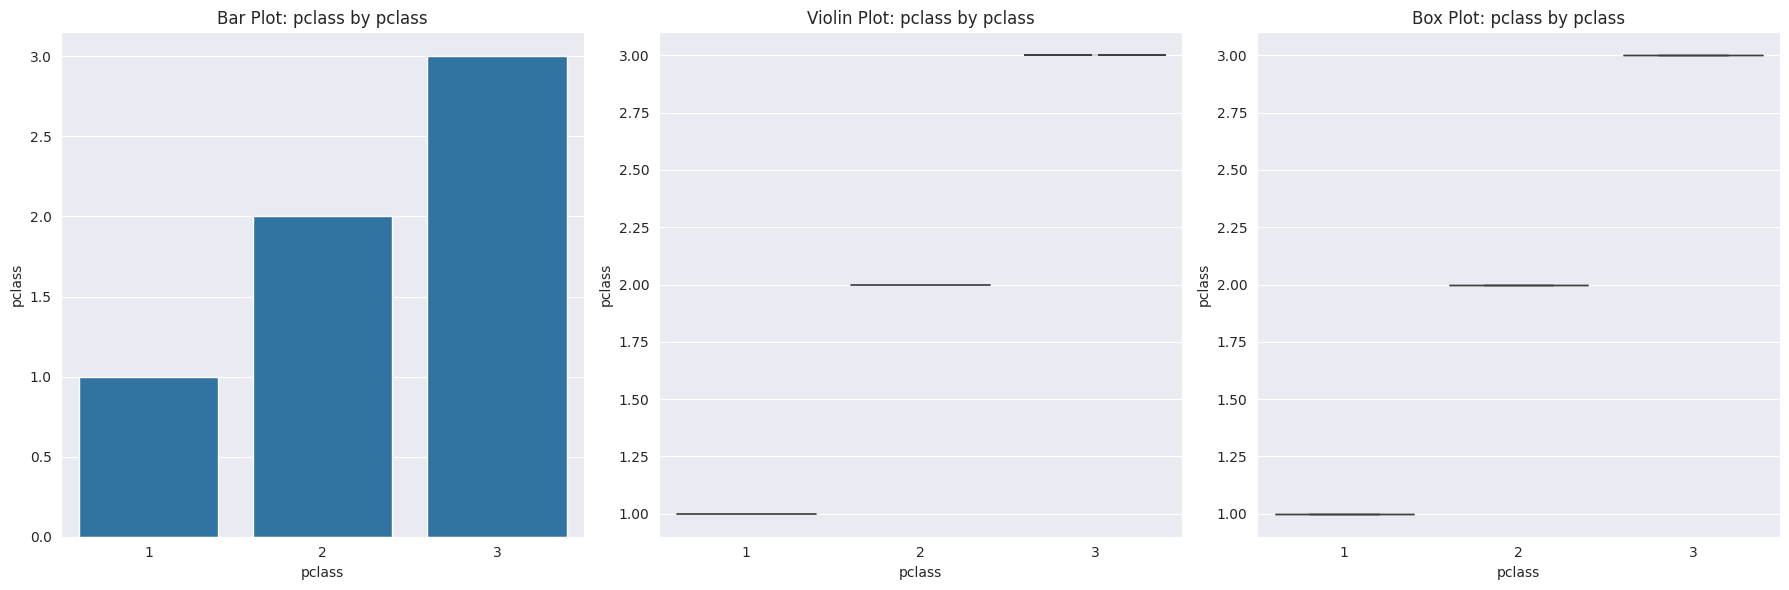

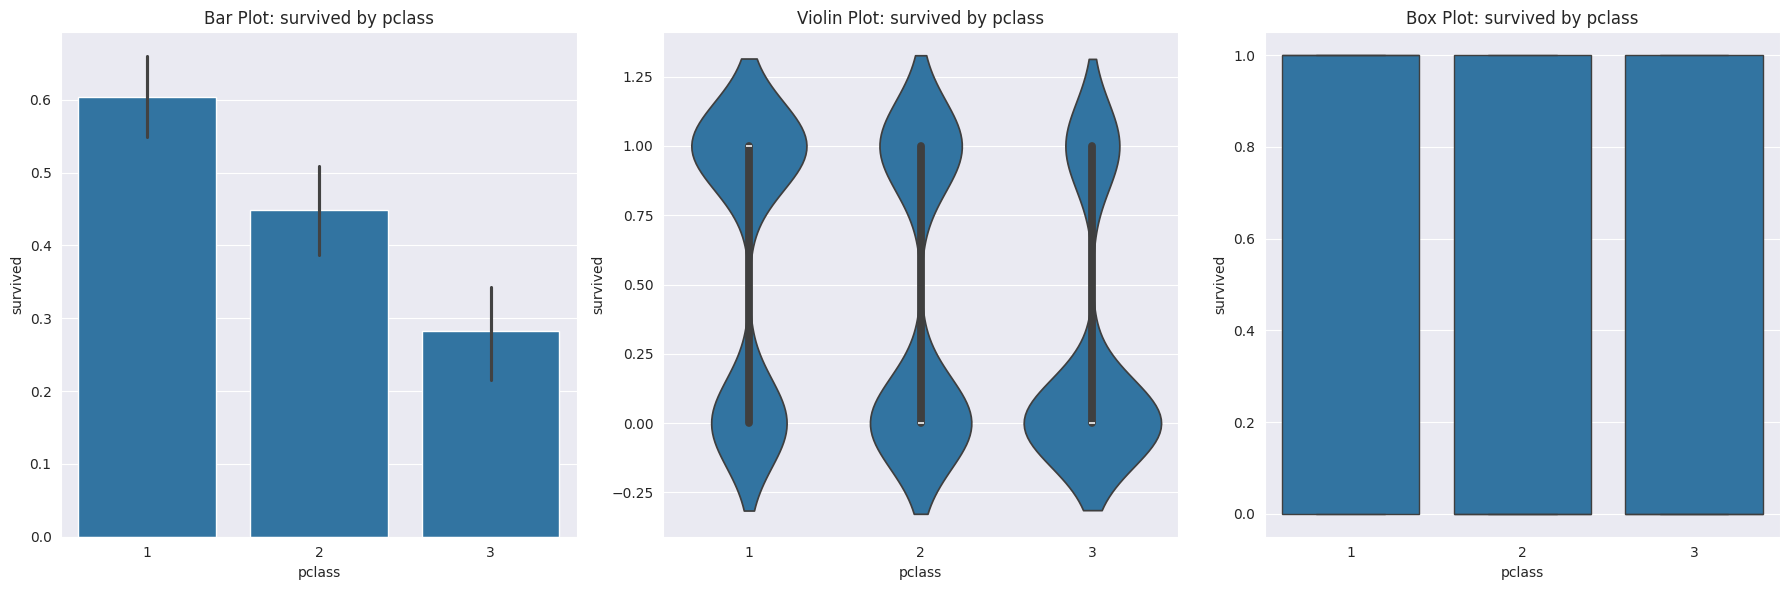

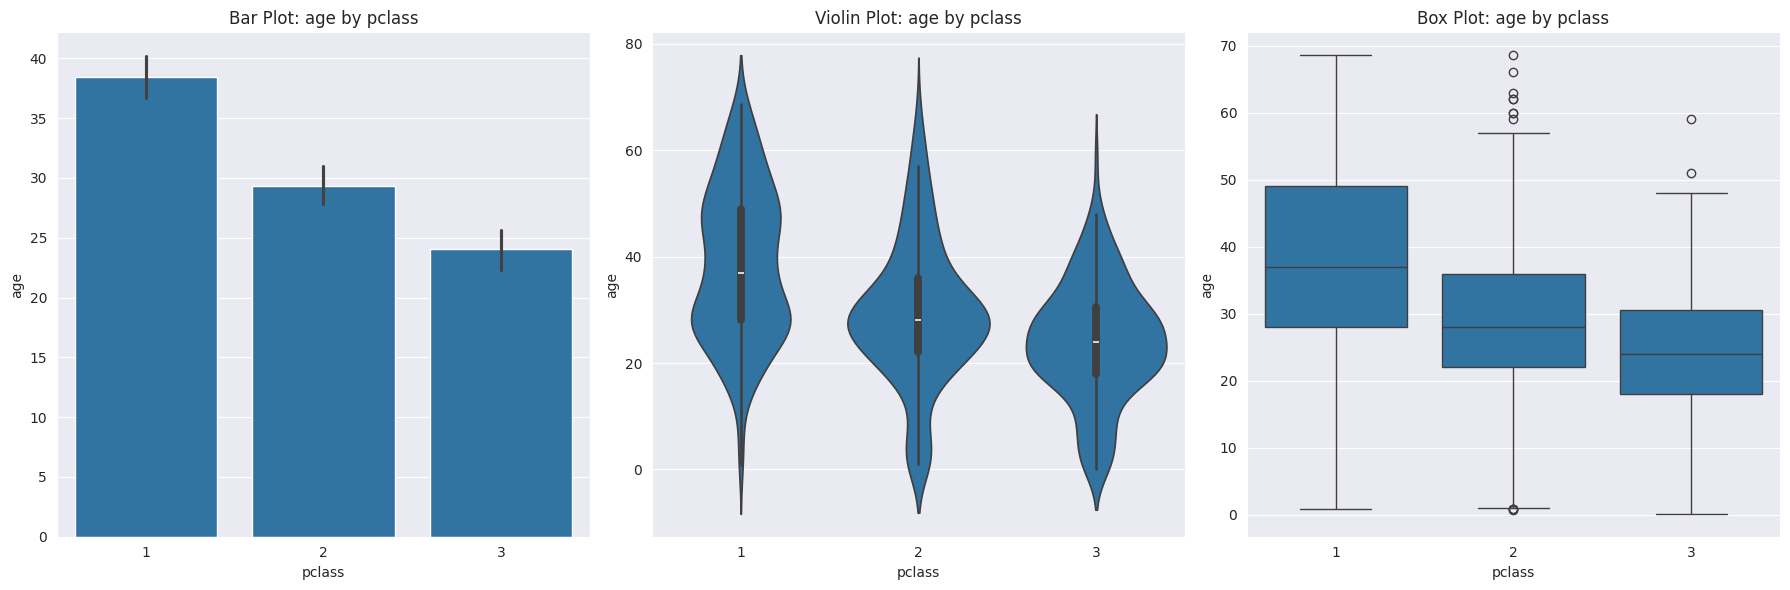

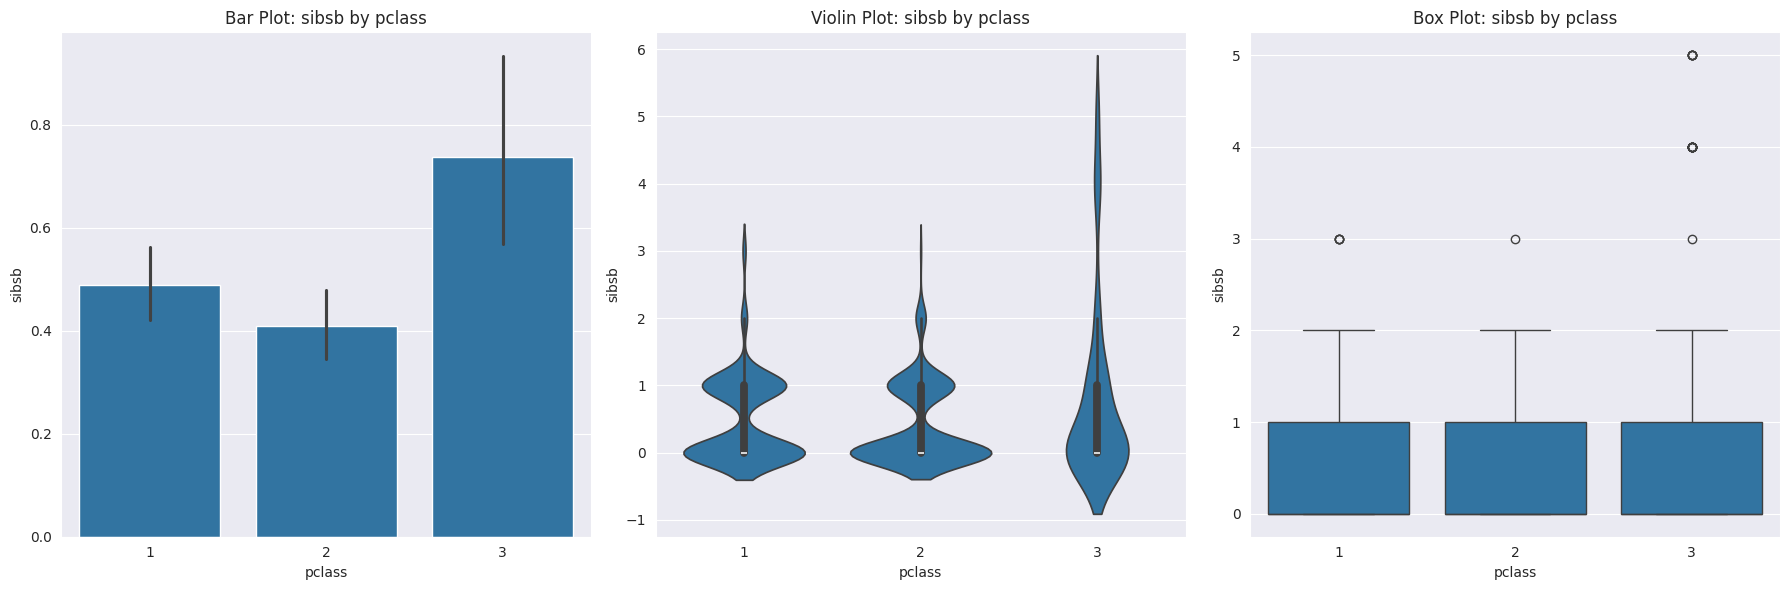

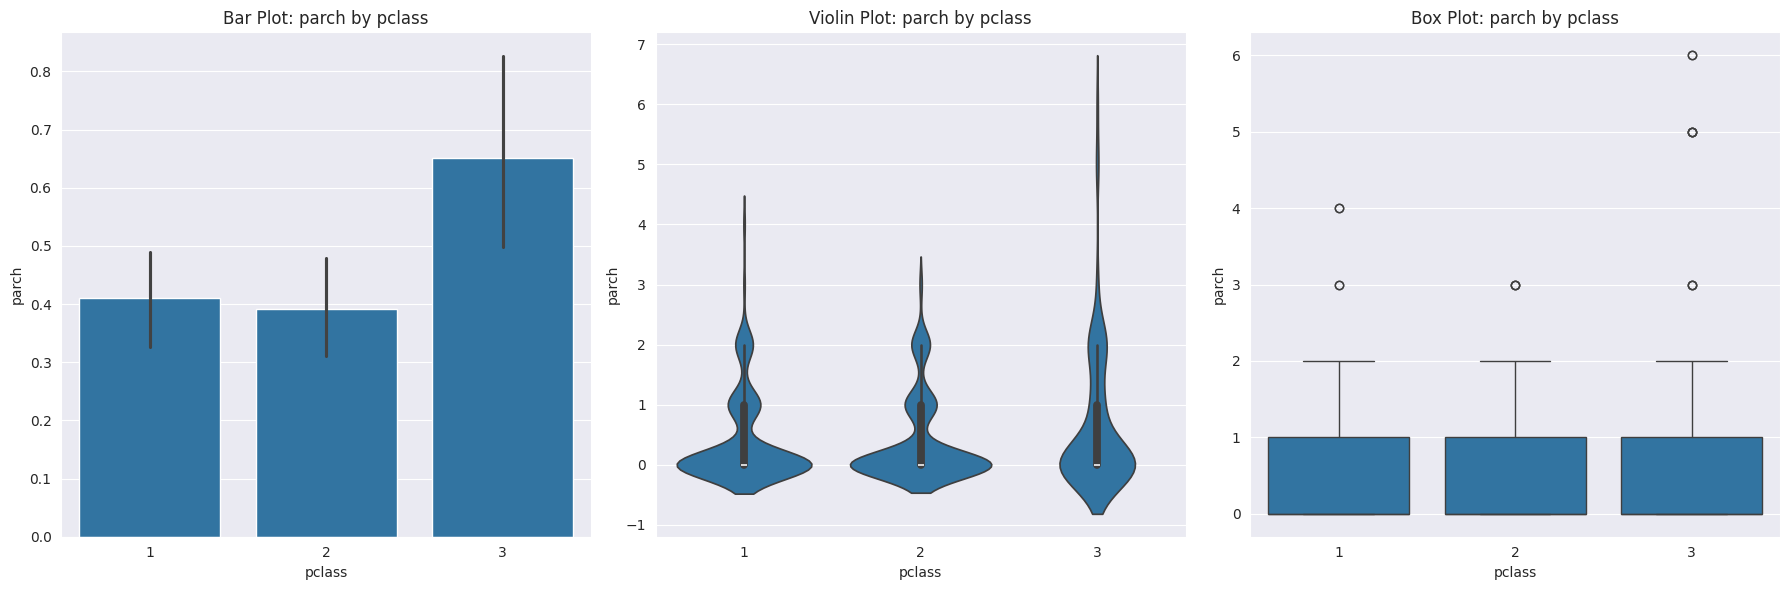

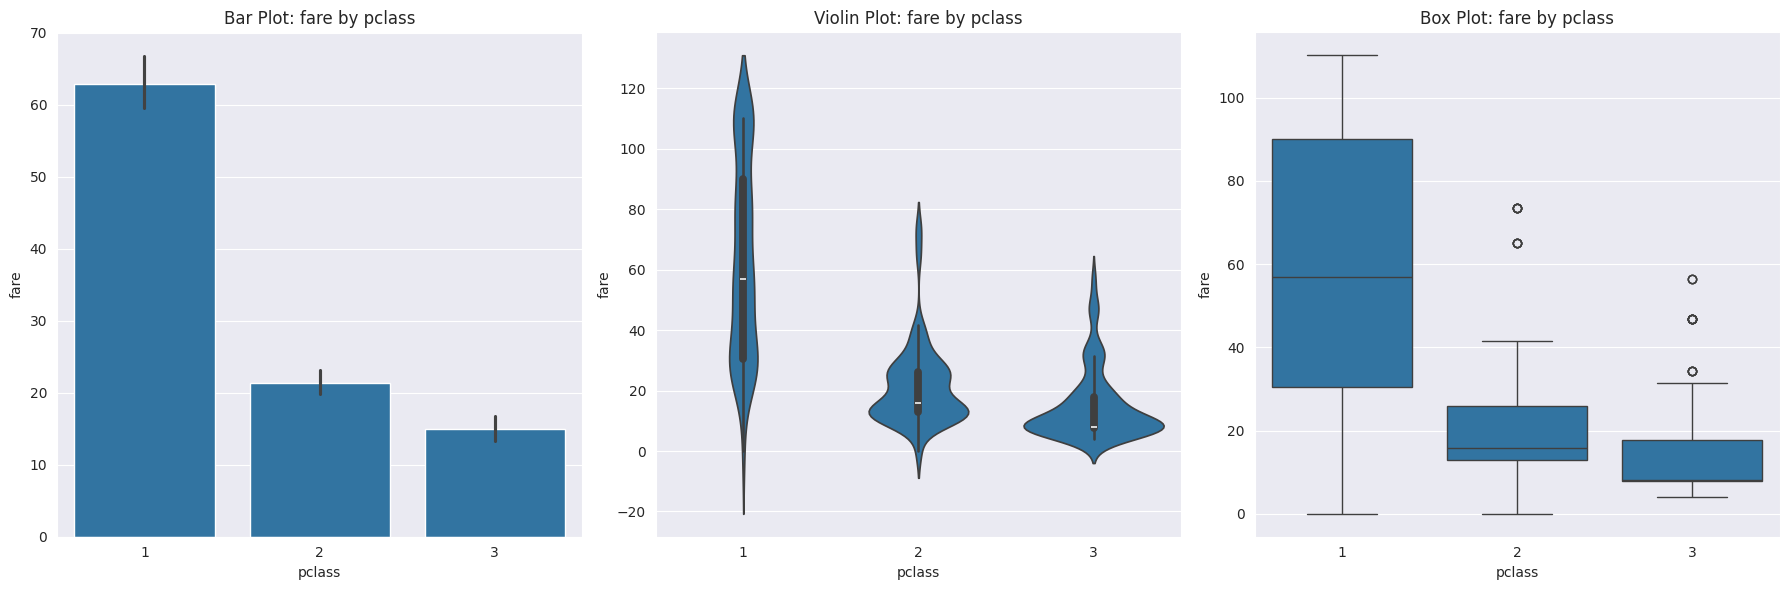

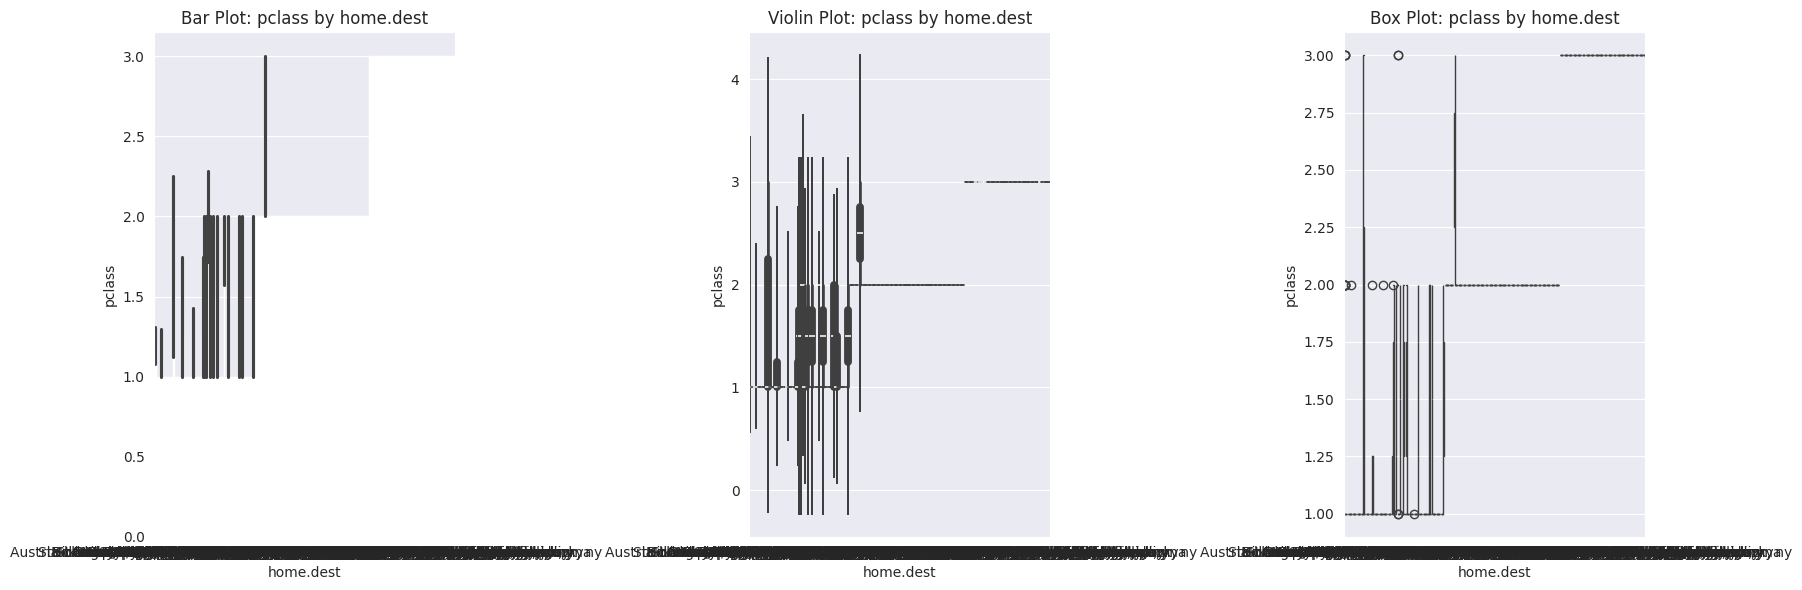

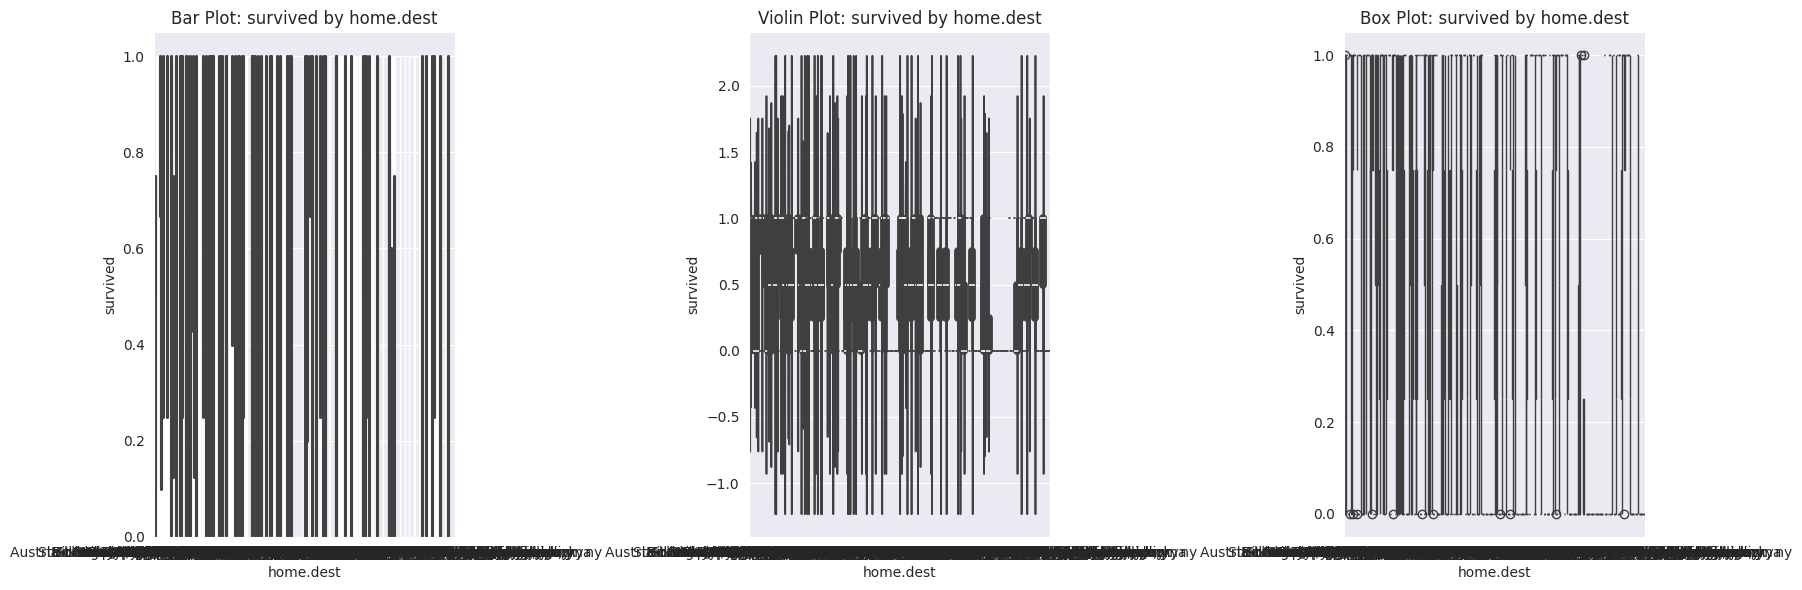

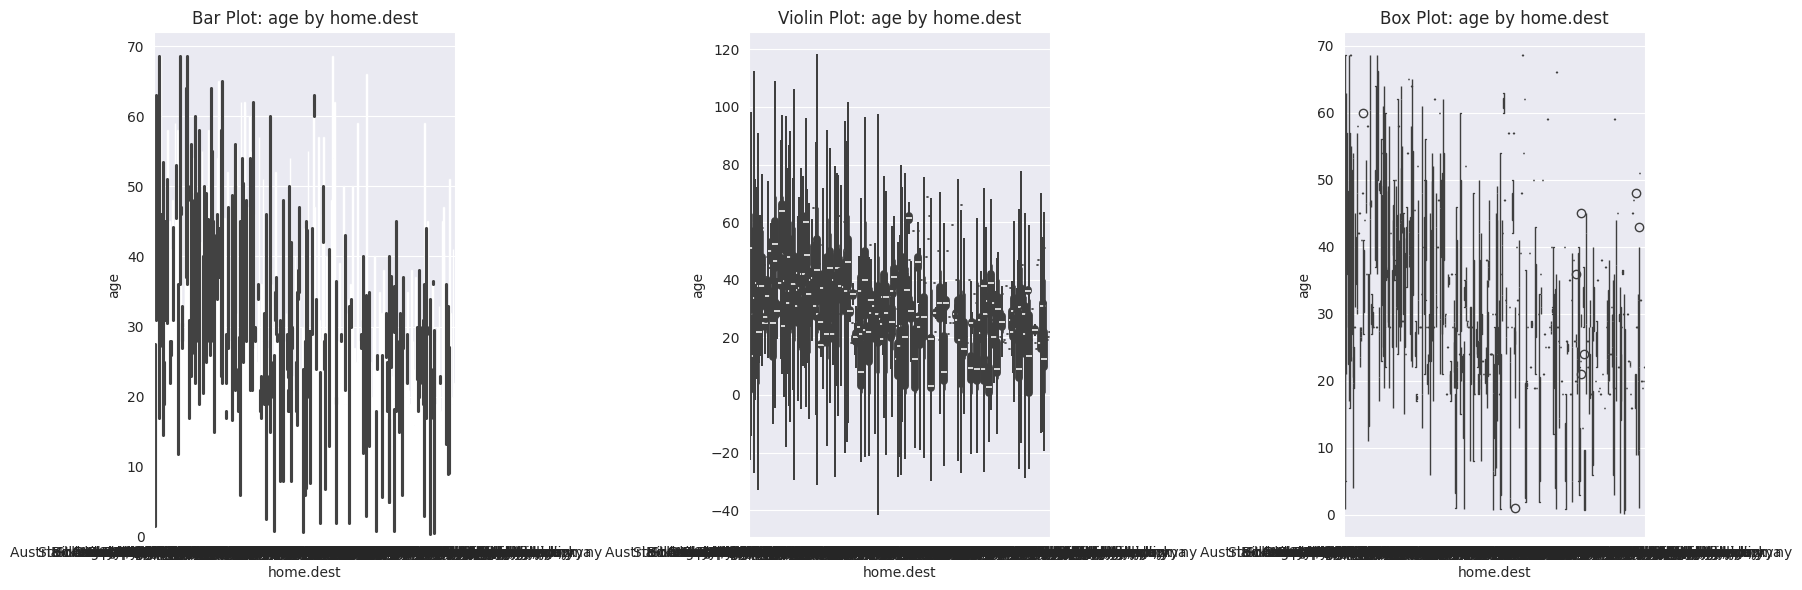

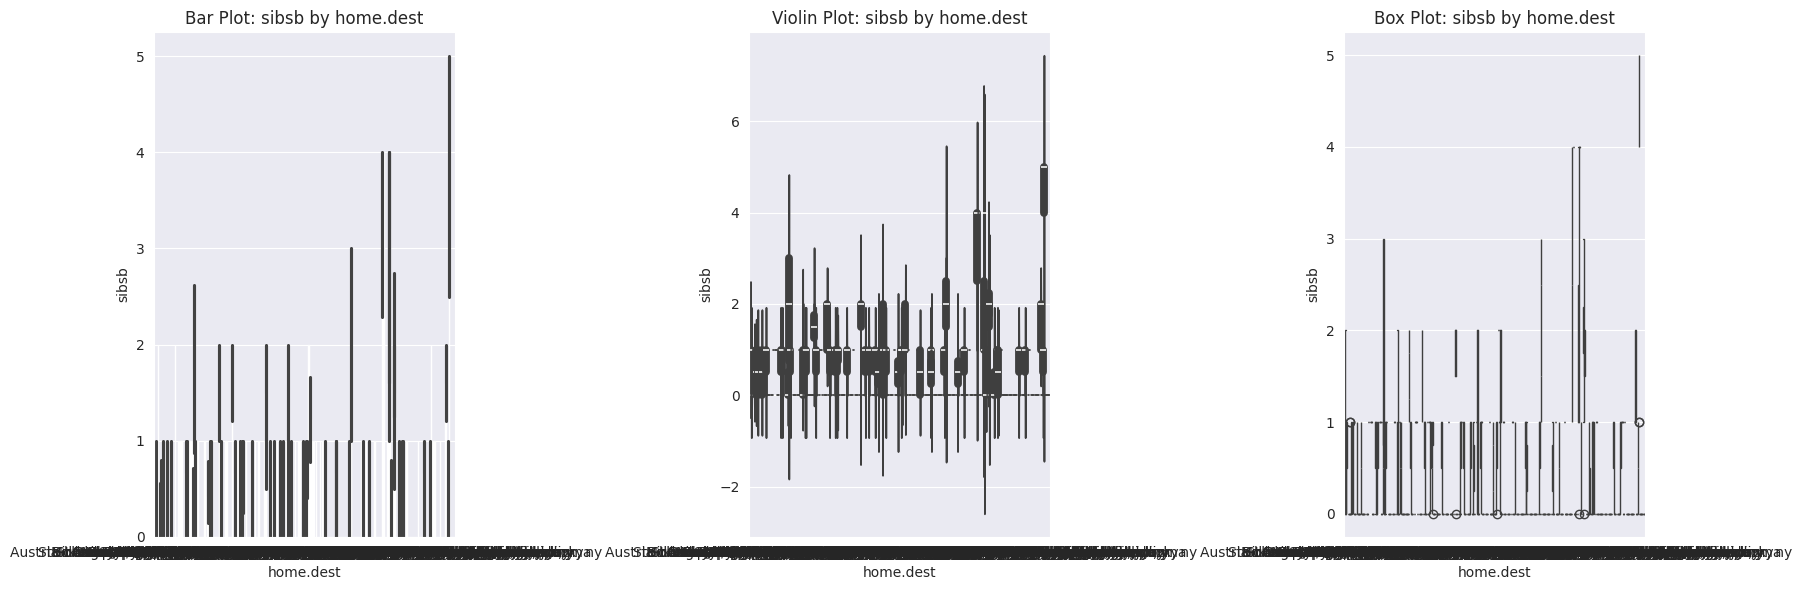

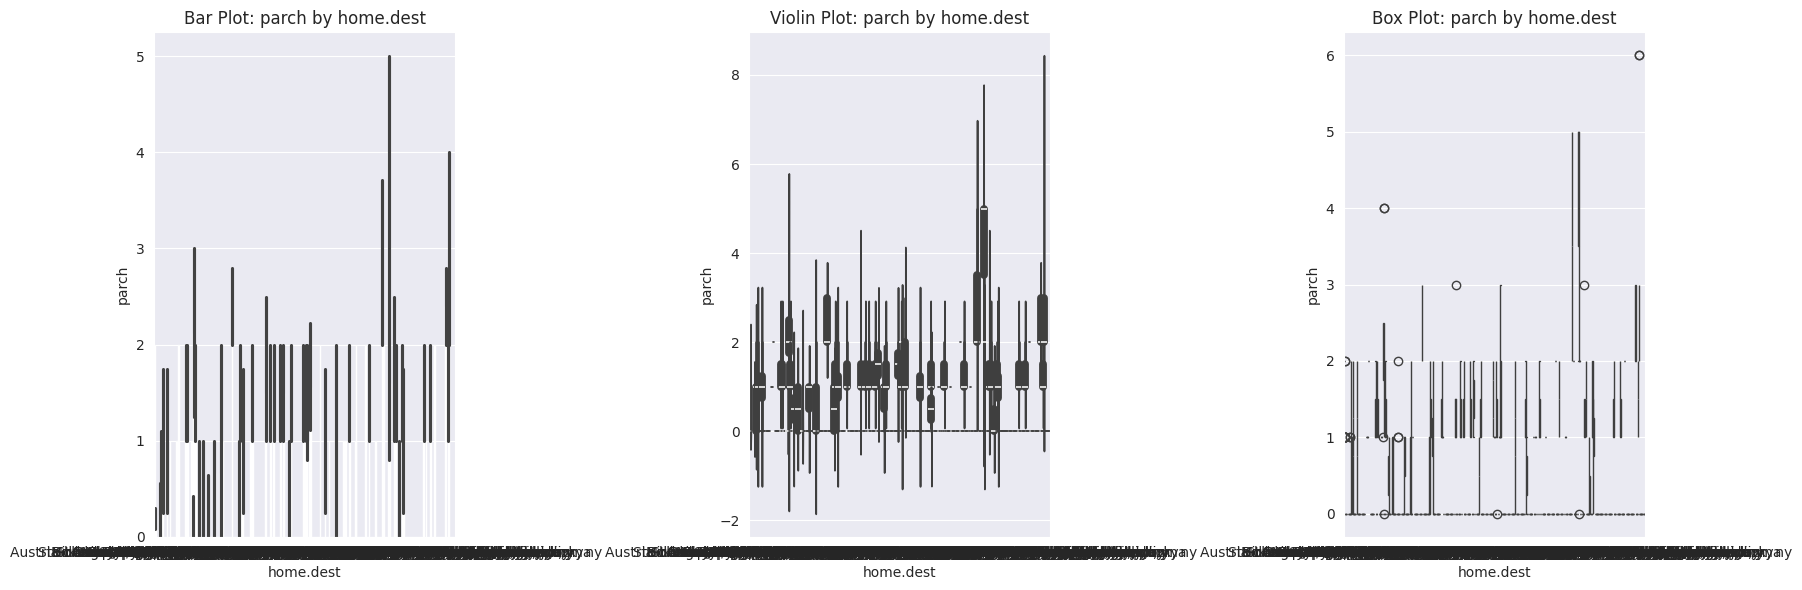

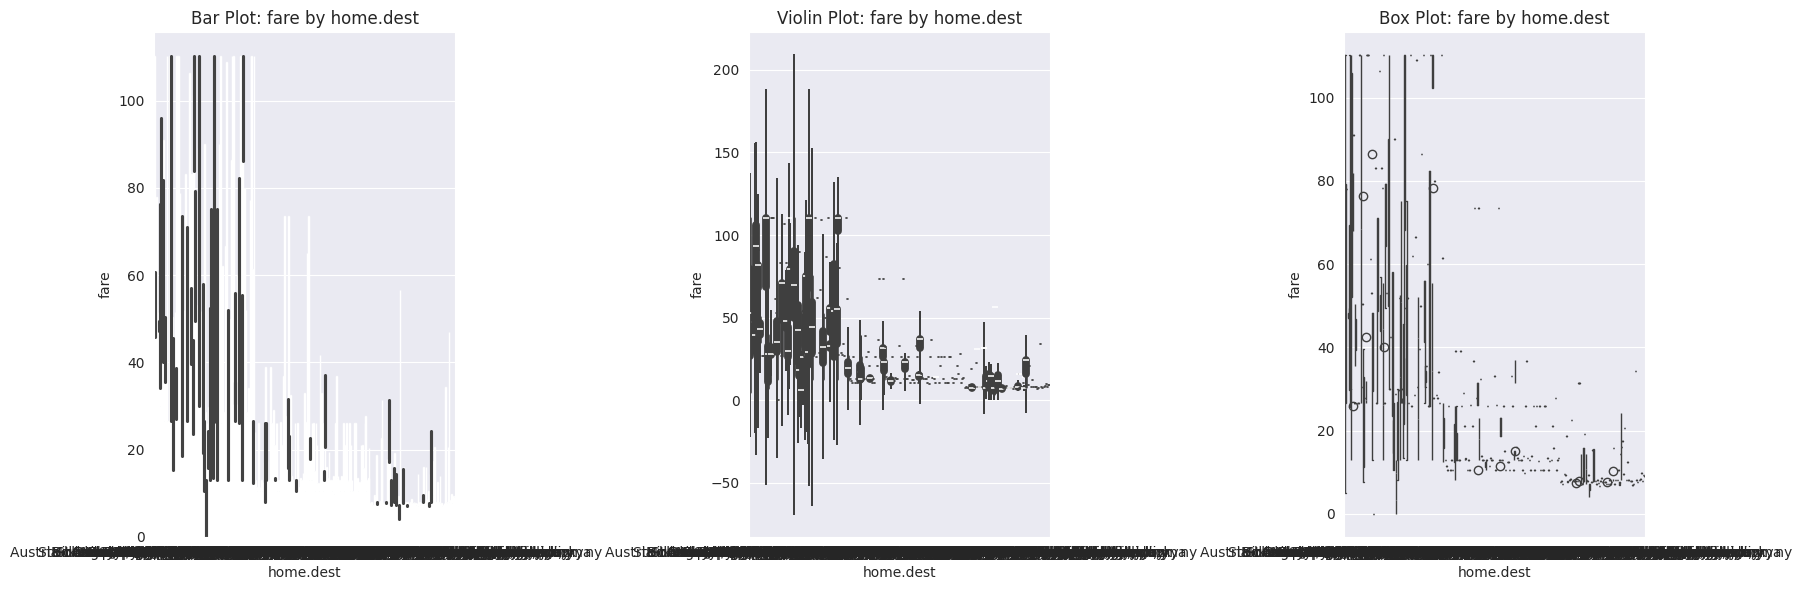

In [31]:
# Bar plots, Violin plots, and Box plots to compare categorical and numerical variables

def categorical_numerical_visuals(df, categorical_cols, numeric_cols):
    for cat_col in categorical_cols:
        for num_col in numeric_cols:
            if cat_col in df.columns and num_col in df.columns:
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                sns.barplot(x=cat_col, y=num_col, data=df)
                plt.title(f"Bar Plot: {num_col} by {cat_col}")

                plt.subplot(1, 3, 2)
                sns.violinplot(x=cat_col, y=num_col, data=df)
                plt.title(f"Violin Plot: {num_col} by {cat_col}")

                plt.subplot(1, 3, 3)
                sns.boxplot(x=cat_col, y=num_col, data=df)
                plt.title(f"Box Plot: {num_col} by {cat_col}")

                plt.tight_layout()
                plt.show()

categorical_numerical_visuals(df, categorical_cols, numeric_cols)


**Multivariate Analysis (Multiple Variables Exploration)**

**Pair plots to analyze multiple relationships simultaneously.**

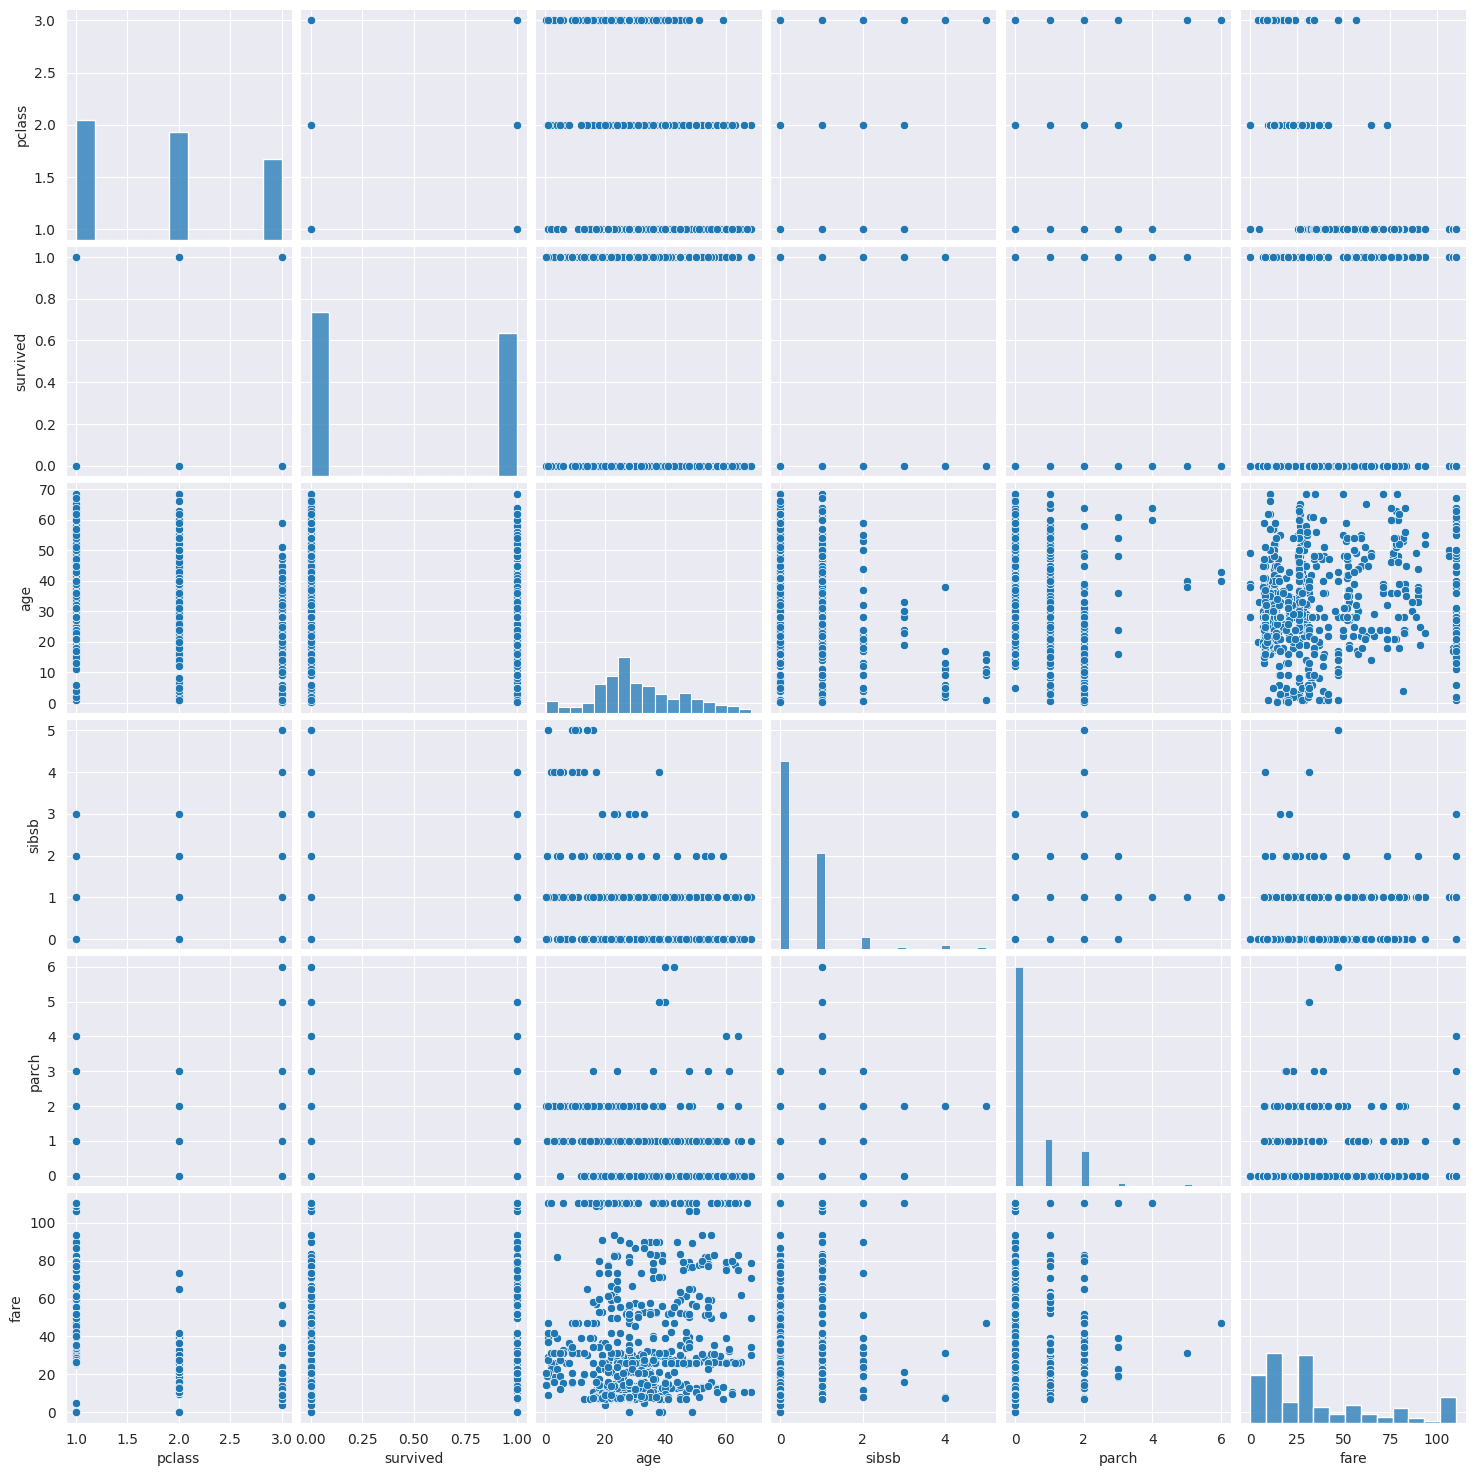

In [32]:
# Pair plots for multiple relationships

sns.pairplot(df[numeric_cols])
plt.show()

**Heatmaps to visualize correlations among multiple variables.**

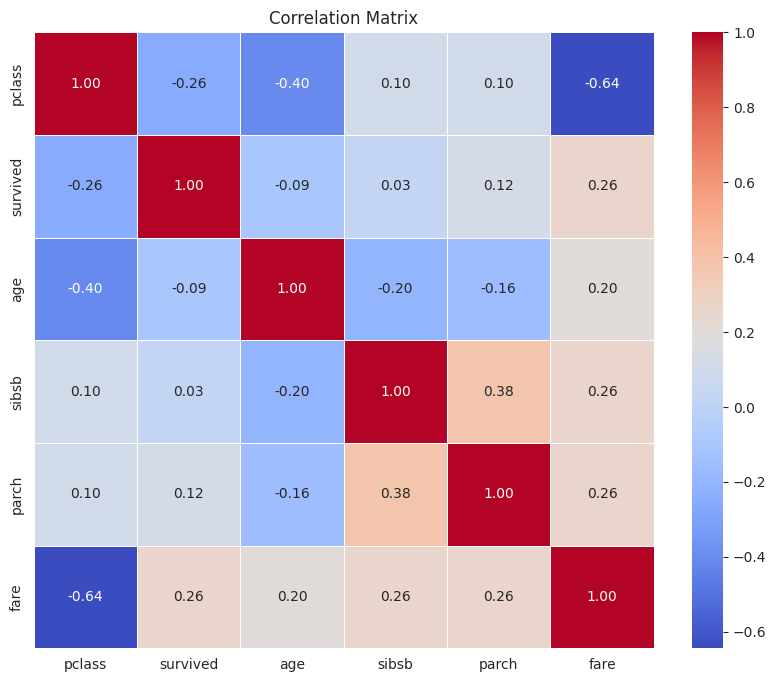

In [34]:
# Correlation matrix (exclude non-numeric columns)

def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

plot_correlation_matrix(df)

**Grouped comparisons to identify combined effects of multiple features.**

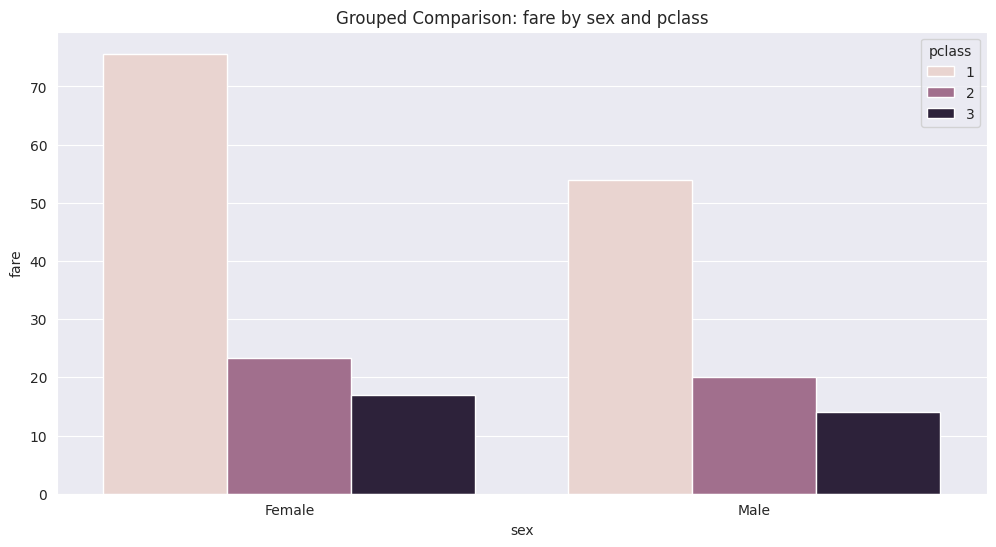

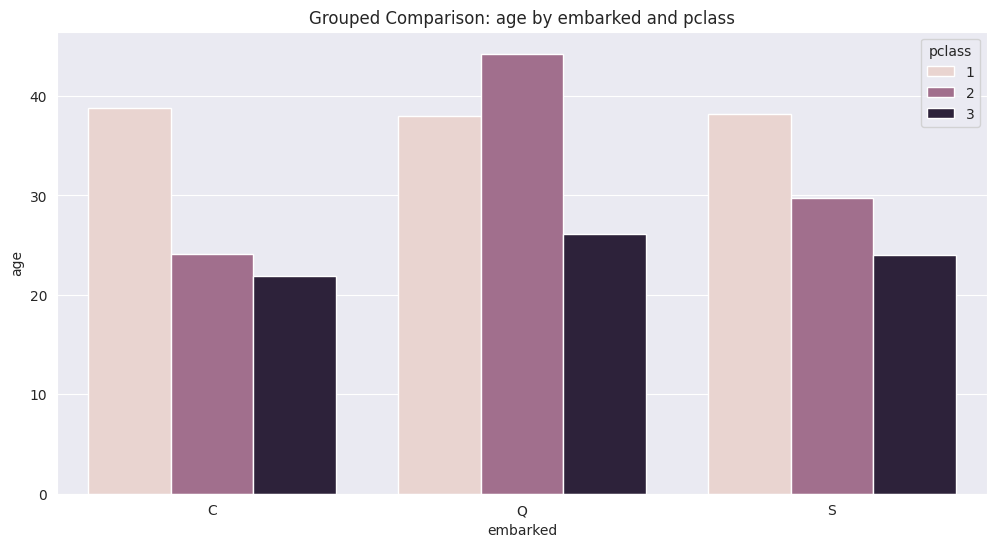

In [35]:
# Grouped comparisons to identify combined effects

def grouped_comparisons(df, group_cols, numeric_col):
    grouped_df = df.groupby(group_cols)[numeric_col].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=group_cols[0], y=numeric_col, hue=group_cols[1], data=grouped_df)
    plt.title(f"Grouped Comparison: {numeric_col} by {group_cols[0]} and {group_cols[1]}")
    plt.show()

grouped_comparisons(df, ['sex', 'pclass'], 'fare')

grouped_comparisons(df, ['embarked', 'pclass'], 'age')